# Credit Score Prediction Model

## 0. Import Packages

In [1]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Data

In [123]:
df = pd.read_csv('home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('home-credit-default-risk/application_test.csv')

## 2. Data Profiling

### 2.1. All Variables

In [3]:
# Show the dimensionality of the data frame (rows, columns)
df.shape

(307511, 122)

In [4]:
df_test.shape

(48744, 121)

In [5]:
# Show the data type for each column
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [6]:
# Show five rows from the data frame
pd.set_option('display.max_columns', None)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
# Check for the null values
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

### 2.2. Target Variable

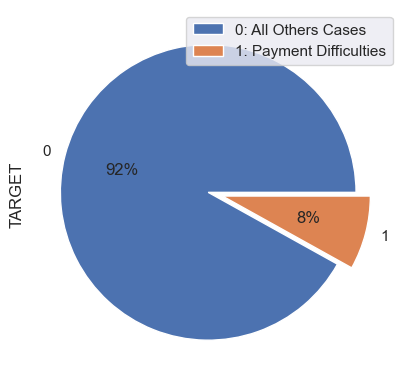

In [141]:
# Check the value of target variable
df['TARGET'].value_counts().plot(kind='pie', autopct="%.0f%%", explode= (0.05, 0.05), legend=True)
plt.legend(["0: All Others Cases","1: Payment Difficulties"]);

In [10]:
# Swap TARGET values of 0 (default) and 1 (not default) for credit scorecard purpose 
df['TARGET'] = df['TARGET'].apply(lambda x: 1 if x == 0 else 0)

### 2.3. Exploratory Data Analysis (EDA)

In [134]:
# Show frequencies of target values by gender
df[['TARGET','CODE_GENDER','SK_ID_CURR']].groupby(by=['TARGET','CODE_GENDER']).count()

SK_ID_CURR
TARGET CODE_GENDER            
0      F                188278
       M                 94404
       XNA                   4
1      F                 14170
       M                 10655

In [135]:
# Show frequencies of target values by education level
df[['TARGET','NAME_EDUCATION_TYPE','SK_ID_CURR']].groupby(by=['TARGET','NAME_EDUCATION_TYPE']).count()

SK_ID_CURR
TARGET NAME_EDUCATION_TYPE                      
0      Academic degree                       161
       Higher education                    70854
       Incomplete higher                    9405
       Lower secondary                      3399
       Secondary / secondary special      198867
1      Academic degree                         3
       Higher education                     4009
       Incomplete higher                     872
       Lower secondary                       417
       Secondary / secondary special       19524

In [140]:
# Show frequencies of target values by income type
pd.set_option('display.max_rows', 15)
df[['TARGET','NAME_INCOME_TYPE','SK_ID_CURR']].groupby(by=['TARGET','NAME_INCOME_TYPE']).count()

SK_ID_CURR
TARGET NAME_INCOME_TYPE                
0      Businessman                   10
       Commercial associate       66257
       Maternity leave                3
       Pensioner                  52380
       State servant              20454
       Student                       18
       Unemployed                    14
       Working                   143550
1      Commercial associate        5360
       Maternity leave                2
       Pensioner                   2982
       State servant               1249
       Unemployed                     8
       Working                    15224

## 3. Data Split

In [11]:
X = df.drop('TARGET', axis = 1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

## 4. Features Selection

In [12]:
# Separate categorical and numerical columns from dataframe
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

### 4.1. Categorical Features

In [13]:
# Categorical features selection technique using chi-squared test
chi2_check = {}
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.merge(X_train_cat.describe().T.reset_index(), 
                  left_on ='Feature', right_on = 'index'
                 ).sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
0,NAME_CONTRACT_TYPE,0.000000,NAME_CONTRACT_TYPE,246008,2,Cash loans,222521
2,FLAG_OWN_CAR,0.000000,FLAG_OWN_CAR,246008,2,N,162453
1,CODE_GENDER,0.000000,CODE_GENDER,246008,3,F,162038
6,NAME_EDUCATION_TYPE,0.000000,NAME_EDUCATION_TYPE,246008,5,Secondary / secondary special,174765
7,NAME_FAMILY_STATUS,0.000000,NAME_FAMILY_STATUS,246008,6,Married,157064
8,NAME_HOUSING_TYPE,0.000000,NAME_HOUSING_TYPE,246008,6,House / apartment,218329
14,WALLSMATERIAL_MODE,0.000000,WALLSMATERIAL_MODE,120988,7,Panel,52839
5,NAME_INCOME_TYPE,0.000000,NAME_INCOME_TYPE,246008,8,Working,127003
9,OCCUPATION_TYPE,0.000000,OCCUPATION_TYPE,168853,18,Laborers,44074
11,ORGANIZATION_TYPE,0.000000,ORGANIZATION_TYPE,246008,58,Business Entity Type 3,54447


In [14]:
# Categorical columns are selected based on subjective judgements  
selected_cat_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 
                     'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']

In [15]:
for cat_col in selected_cat_cols:
    print(cat_col) 
    print(X_train[cat_col].unique())

FLAG_OWN_CAR
['N' 'Y']
CODE_GENDER
['F' 'M' 'XNA']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Married' 'Separated' 'Single / not married' 'Widow' 'Civil marriage'
 'Unknown']
NAME_INCOME_TYPE
['Pensioner' 'Commercial associate' 'Working' 'State servant' 'Student'
 'Unemployed' 'Maternity leave' 'Businessman']
OCCUPATION_TYPE
[nan 'Sales staff' 'Drivers' 'Core staff' 'Managers'
 'Private service staff' 'Medicine staff' 'Laborers'
 'Waiters/barmen staff' 'High skill tech staff' 'Secretaries'
 'Cleaning staff' 'Accountants' 'Cooking staff' 'Security staff'
 'IT staff' 'Low-skill Laborers' 'Realty agents' 'HR staff']


In [16]:
# Convert CODE_GENDER's XNA values to F
X_train['CODE_GENDER'] = X_train['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

In [17]:
# Convert NAME_FAMILY_STATUS's Unknown values to into Single / not married
X_train['NAME_FAMILY_STATUS'] = X_train['NAME_FAMILY_STATUS'].apply(lambda x: 'Single / not married' if x == 'Unknown' else x)

In [18]:
# Convert OCCUPATION_TYPE's Businessman, Maternity leave, and Student values to Working or Unemployed
def income_type(name):
    if name == 'Businessman' or name ==  'Maternity leave':
        return 'Working'
    elif name == 'Student':
        return 'Unemployed'
    else: 
        return name
X_train['NAME_INCOME_TYPE'] = X_train['NAME_INCOME_TYPE'].apply(income_type)

In [19]:
# One-hot encoding to categorical columns
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

X_train = dummy_creation(X_train, selected_cat_cols)
X_test = dummy_creation(X_test, selected_cat_cols)

X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

### 4.2. Numerical Features

In [20]:
# Numerical features selection technique using ANOVA F test
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 
                                     'F-Score': F_statistic, 
                                     'p values': p_values.round(decimals=10)}
                                    ).sort_values(by=['F-Score'], ascending=False)

In [21]:
ANOVA_F_table

,Numerical_Feature,F-Score,p values
29,EXT_SOURCE_2,6518.576280,0.000000
30,EXT_SOURCE_3,5995.804669,0.000000
28,EXT_SOURCE_1,2496.684508,0.000000
7,DAYS_BIRTH,1522.372017,0.000000
20,REGION_RATING_CLIENT_W_CITY,913.906244,0.000000
...,...,...,...
101,AMT_REQ_CREDIT_BUREAU_WEEK,0.112686,0.737107
82,FLAG_DOCUMENT_5,0.090312,0.763781
12,FLAG_MOBIL,0.087821,0.766965
99,AMT_REQ_CREDIT_BUREAU_HOUR,0.058616,0.808698


<AxesSubplot:>

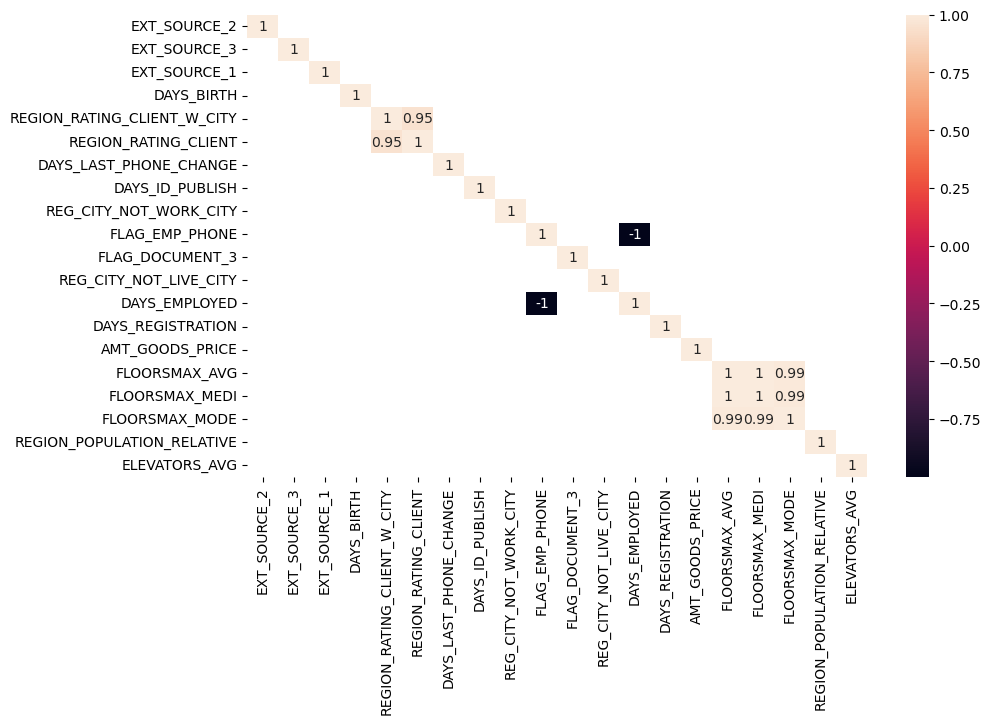

In [22]:
# Calculate pair-wise correlations between top 20 numerical features
temp_selected_num_cols = ANOVA_F_table.iloc[:20,0].to_list()
corr_mat = X_train_num[temp_selected_num_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=True, mask = (abs(corr_mat) <= 0.7))

In [23]:
selected_num_cols = []
# Numerical columns are dropped due to its multicollinearity
dropped_num_cols = ['REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','FLAG_EMP_PHONE','DAYS_EMPLOYED',
                    'FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE']
for col in temp_selected_num_cols:
    if col in dropped_num_cols:
        pass
    else:
        selected_num_cols.append(col)
print(selected_num_cols)

['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'ELEVATORS_AVG']


In [24]:
X_train[selected_num_cols].describe()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,DAYS_REGISTRATION,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,ELEVATORS_AVG
count,2.454690e+05,197141.000000,107420.000000,246008.000000,246007.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,2.457840e+05,246008.000000,114941.000000
mean,5.142588e-01,0.510714,0.501780,-16029.807331,-963.105456,-2993.689616,0.230395,0.709623,0.078018,-4991.218237,5.383531e+05,0.020859,0.078524
std,1.911241e-01,0.194946,0.210815,4359.823101,827.031758,1509.386678,0.421086,0.453937,0.268200,3524.413603,3.690571e+05,0.013827,0.134064
min,8.173617e-08,0.000527,0.014568,-25229.000000,-4292.000000,-7197.000000,0.000000,0.000000,0.000000,-24672.000000,4.050000e+04,0.000290,0.000000
25%,3.920716e-01,0.370650,0.334022,-19673.000000,-1570.000000,-4298.000000,0.000000,0.000000,0.000000,-7486.000000,2.385000e+05,0.010006,0.000000
50%,5.658325e-01,0.535276,0.505721,-15739.000000,-757.000000,-3256.000000,0.000000,1.000000,0.000000,-4511.000000,4.500000e+05,0.018850,0.000000
75%,6.636269e-01,0.669057,0.674091,-12410.000000,-274.000000,-1716.000000,0.000000,1.000000,0.000000,-2014.000000,6.795000e+05,0.028663,0.120000
max,8.549997e-01,0.896010,0.951624,-7489.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.050000e+06,0.072508,1.000000


In [25]:
# Handling missing numerical values with imputer
my_imputer = SimpleImputer(strategy='median')
X_train[selected_num_cols] = my_imputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = my_imputer.transform(X_test[selected_num_cols])

### 4.3. Combined Features

In [26]:
selected_cols = selected_cat_cols + selected_num_cols

## 5. Feature Engineering: Binning

In [27]:
pd.DataFrame({'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
              'Variable Predictiveness' : ['Not useful for prediction',
                                           'Weak predictive power',
                                           'Medium Predictive Power',
                                           'Strong predictive power',
                                           'Suspicious predictive power']}).style.hide_index()

Information Value,Variable Predictiveness
< 0.02,Not useful for prediction
0.02 - 0.1,Weak predictive power
0.1 - 0.3,Medium Predictive Power
0.3 - 0.5,Strong predictive power
> 0.5,Suspicious predictive power


### 5.1. Categorical Features

In [28]:
sns.set()
def woe_discrete(df, cat_cols, y_df):
    ''''Function to calculate WoE and IV of categorical features'''
    df = pd.concat([df[cat_cols], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    plt.figure(figsize=(18, 6))
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = 0)
    plt.show()
    
    return df

In [29]:
selected_cat_cols

['FLAG_OWN_CAR',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE',
 'OCCUPATION_TYPE']

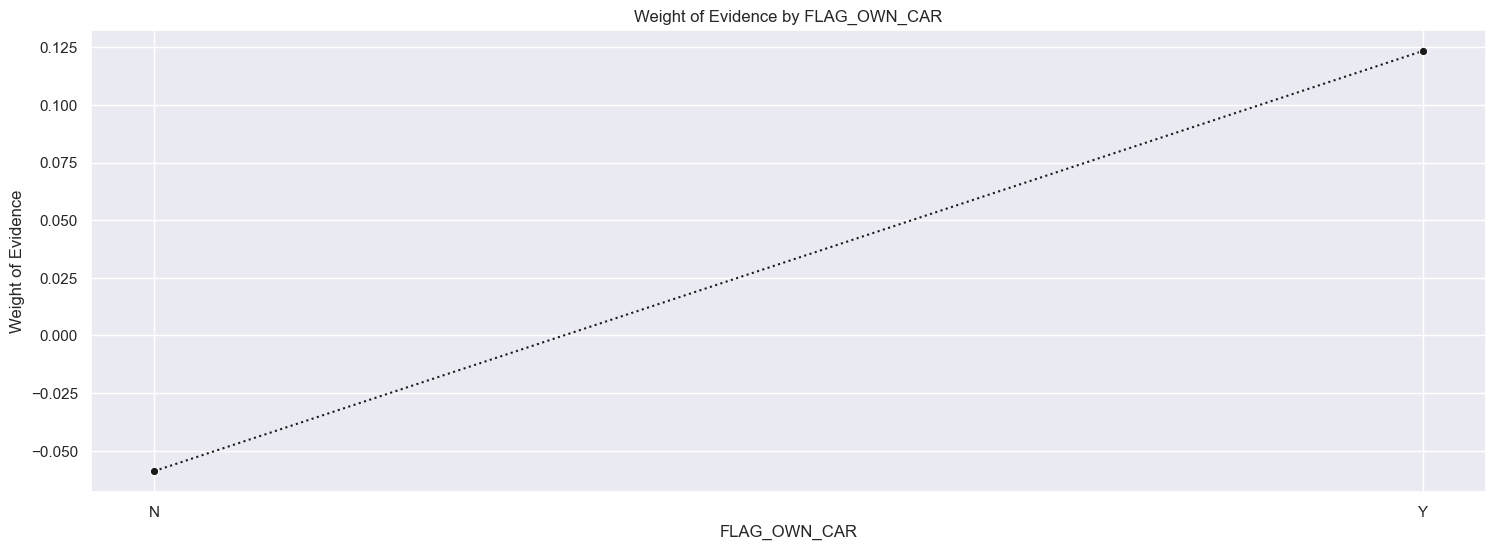

,FLAG_OWN_CAR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,N,162453,0.914800,0.660357,148612.0,13841.0,0.657145,0.696928,-0.058778,NaN,NaN,0.007245
1,Y,83555,0.927964,0.339643,77536.0,6019.0,0.342855,0.303072,0.123339,0.013164,0.182118,0.007245


In [30]:
woe_discrete(X_train,'FLAG_OWN_CAR', y_train)

In [31]:
# FLAG_OWN_CAR is not useful for prediction (IV < 0.2)

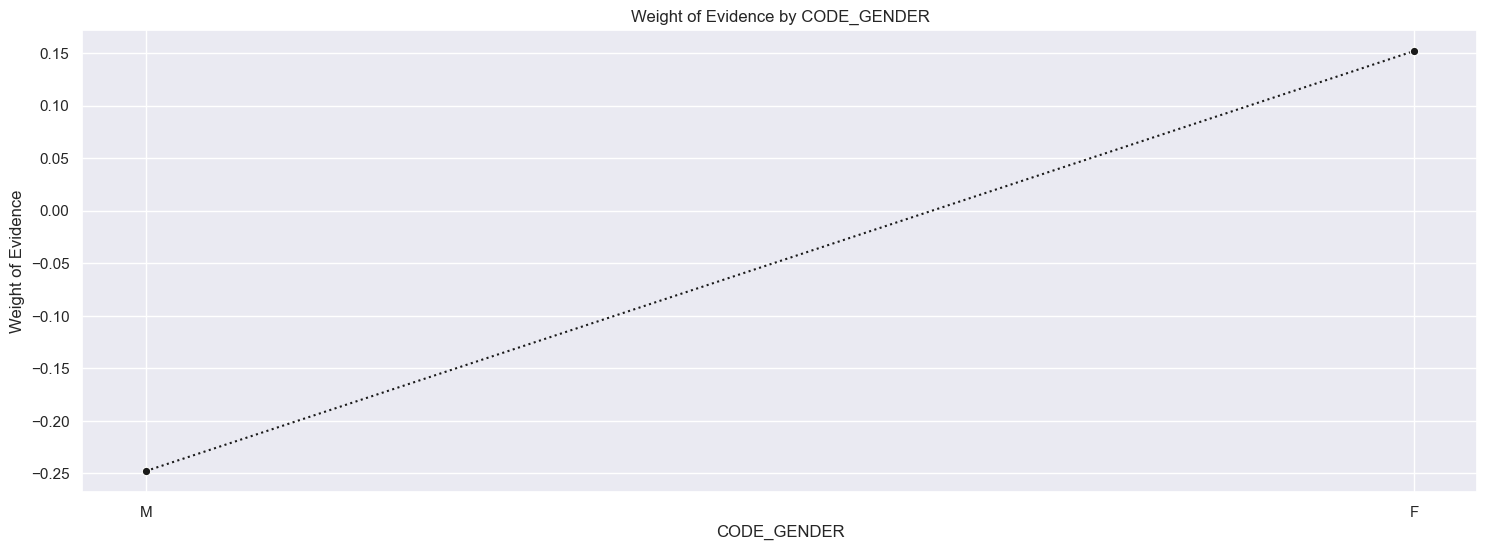

,CODE_GENDER,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,M,83968,0.898866,0.341322,75476.0,8492.0,0.333746,0.427593,-0.247792,NaN,NaN,0.037502
1,F,162040,0.929844,0.658678,150672.0,11368.0,0.666254,0.572407,0.151821,0.030978,0.399613,0.037502


In [32]:
woe_discrete(X_train,'CODE_GENDER', y_train)

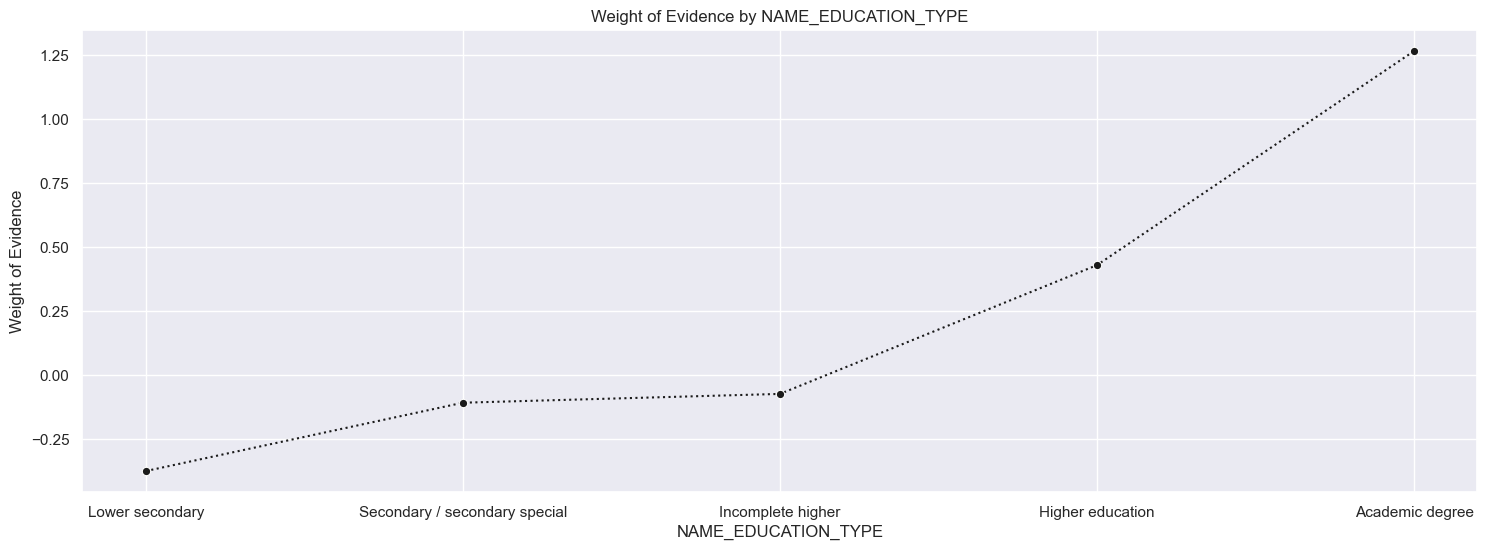

,NAME_EDUCATION_TYPE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Lower secondary,3030,0.886799,0.012317,2687.0,343.0,0.011882,0.017271,-0.374032,NaN,NaN,0.048773
1,Secondary / secondary special,174765,0.910932,0.710404,159199.0,15566.0,0.703959,0.783787,-0.107416,0.024133,0.266616,0.048773
2,Incomplete higher,8260,0.913680,0.033576,7547.0,713.0,0.033372,0.035901,-0.073058,0.002749,0.034358,0.048773
3,Higher education,59829,0.945929,0.243199,56594.0,3235.0,0.250252,0.162890,0.429392,0.032249,0.502450,0.048773
4,Academic degree,124,0.975806,0.000504,121.0,3.0,0.000535,0.000151,1.264696,0.029877,0.835304,0.048773


In [33]:
woe_discrete(X_train,'NAME_EDUCATION_TYPE', y_train)

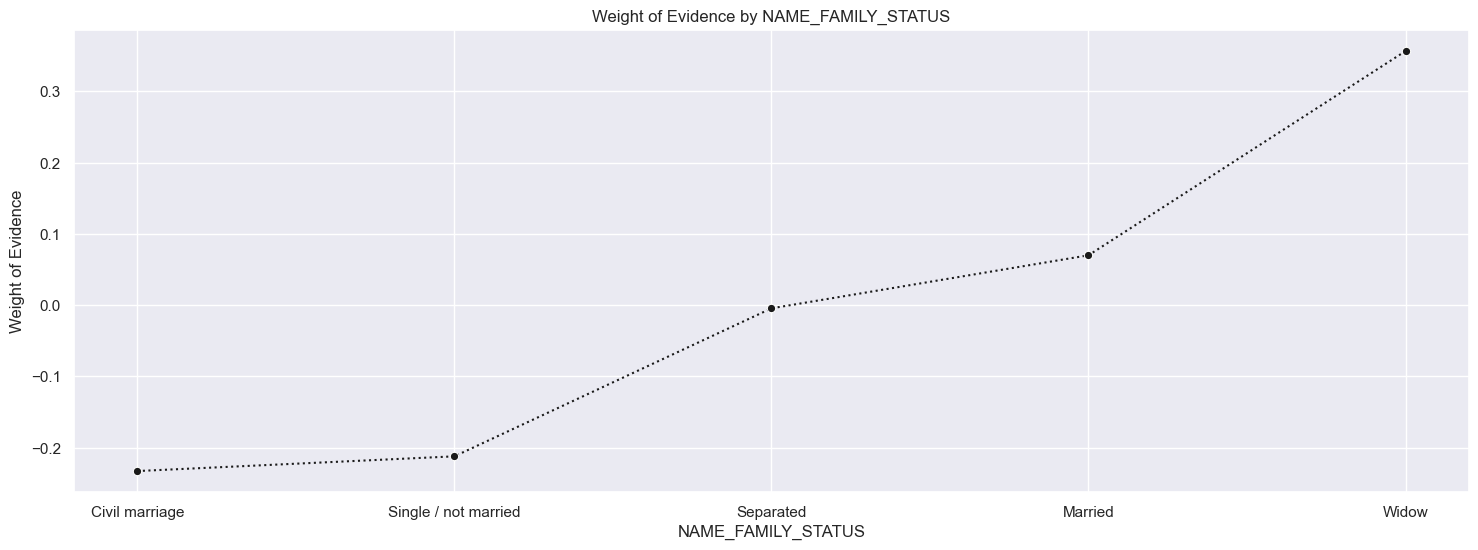

,NAME_FAMILY_STATUS,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Civil marriage,23864,0.900226,0.097005,21483.0,2381.0,0.094995,0.119889,-0.232741,NaN,NaN,0.021832
1,Single / not married,36381,0.902064,0.147885,32818.0,3563.0,0.145117,0.179406,-0.212108,0.001838,0.020633,0.021832
2,Separated,15853,0.918943,0.064441,14568.0,1285.0,0.064418,0.064703,-0.004413,0.016879,0.207694,0.021832
3,Married,157064,0.924317,0.638451,145177.0,11887.0,0.641956,0.598540,0.070026,0.005375,0.074440,0.021832
4,Widow,12846,0.942083,0.052218,12102.0,744.0,0.053514,0.037462,0.356603,0.017766,0.286577,0.021832


In [34]:
woe_discrete(X_train,'NAME_FAMILY_STATUS', y_train)

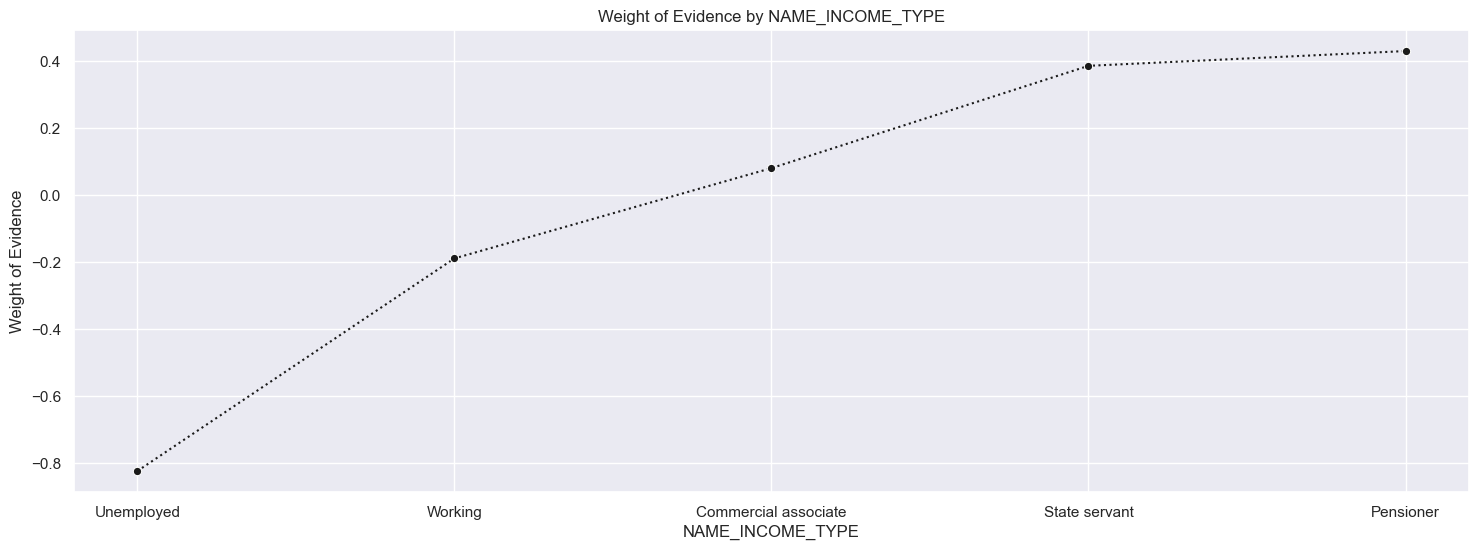

,NAME_INCOME_TYPE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Unemployed,30,0.833333,0.000122,25.0,5.0,0.000111,0.000252,-0.823044,NaN,NaN,0.058216
1,Working,127017,0.904076,0.516312,114833.0,12184.0,0.507778,0.613494,-0.189127,0.070742,0.633917,0.058216
2,Commercial associate,57266,0.925017,0.232781,52972.0,4294.0,0.234236,0.216213,0.080063,0.020941,0.269189,0.058216
3,State servant,17505,0.943616,0.071156,16518.0,987.0,0.073041,0.049698,0.385054,0.018600,0.304991,0.058216
4,Pensioner,44190,0.945915,0.179628,41800.0,2390.0,0.184835,0.120342,0.429121,0.002299,0.044067,0.058216


In [35]:
woe_discrete(X_train,'NAME_INCOME_TYPE', y_train)

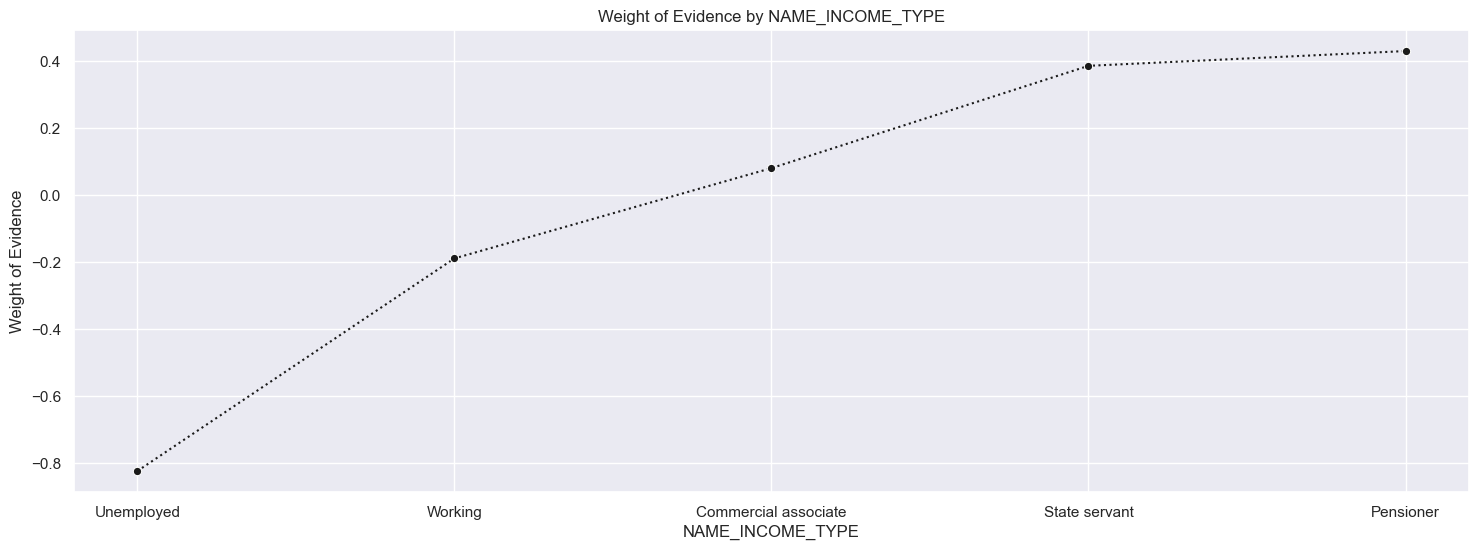

,NAME_INCOME_TYPE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Unemployed,30,0.833333,0.000122,25.0,5.0,0.000111,0.000252,-0.823044,NaN,NaN,0.058216
1,Working,127017,0.904076,0.516312,114833.0,12184.0,0.507778,0.613494,-0.189127,0.070742,0.633917,0.058216
2,Commercial associate,57266,0.925017,0.232781,52972.0,4294.0,0.234236,0.216213,0.080063,0.020941,0.269189,0.058216
3,State servant,17505,0.943616,0.071156,16518.0,987.0,0.073041,0.049698,0.385054,0.018600,0.304991,0.058216
4,Pensioner,44190,0.945915,0.179628,41800.0,2390.0,0.184835,0.120342,0.429121,0.002299,0.044067,0.058216


In [36]:
woe_discrete(X_train,'NAME_INCOME_TYPE', y_train)

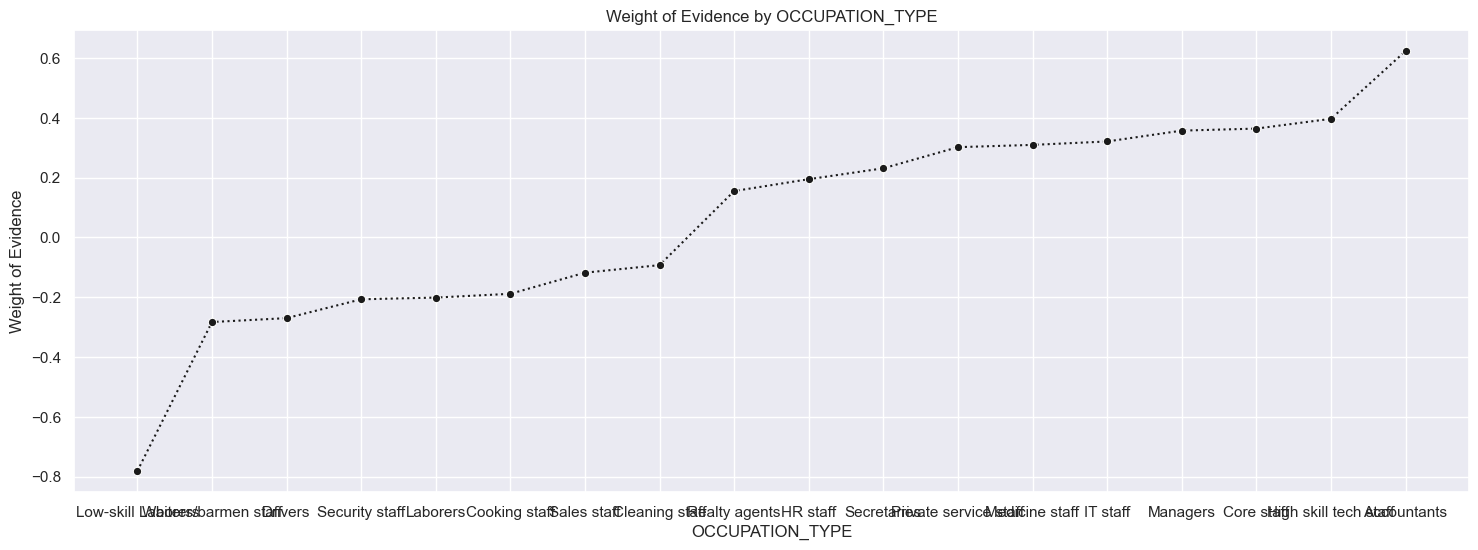

,OCCUPATION_TYPE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Low-skill Laborers,1651,0.826772,0.009778,1365.0,286.0,0.008859,0.019353,-0.781382,NaN,NaN,0.084879
1,Waiters/barmen staff,1107,0.887082,0.006556,982.0,125.0,0.006374,0.008459,-0.283022,0.060311,0.498360,0.084879
2,Drivers,14944,0.888383,0.088503,13276.0,1668.0,0.086166,0.112870,-0.269967,0.001301,0.013055,0.084879
3,Security staff,5373,0.894472,0.031821,4806.0,567.0,0.031193,0.038368,-0.207039,0.006089,0.062929,0.084879
4,Laborers,44074,0.895017,0.261020,39447.0,4627.0,0.256025,0.313101,-0.201251,0.000545,0.005788,0.084879
5,Cooking staff,4759,0.896197,0.028184,4265.0,494.0,0.027681,0.033428,-0.188638,0.001179,0.012613,0.084879
6,Sales staff,25623,0.902588,0.151747,23127.0,2496.0,0.150102,0.168900,-0.117989,0.006391,0.070649,0.084879
7,Cleaning staff,3739,0.904787,0.022144,3383.0,356.0,0.021957,0.024090,-0.092712,0.002200,0.025276,0.084879
8,Realty agents,606,0.924092,0.003589,560.0,46.0,0.003635,0.003113,0.154995,0.019305,0.247708,0.084879
9,HR staff,451,0.926829,0.002671,418.0,33.0,0.002713,0.002233,0.194674,0.002737,0.039678,0.084879


In [37]:
woe_discrete(X_train,'OCCUPATION_TYPE', y_train)

### 5.2. Numerical Features

In [38]:
def woe_ordered_continuous(df, num_cols, y_df):
    ''''Function to calculate WoE and IV of numerical features'''
    df = pd.concat([df[num_cols], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    plt.figure(figsize=(18, 6))
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = 0)
    plt.show()
    
    return df

In [39]:
X_train[selected_num_cols].nunique().sort_values()

REG_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_3                    2
REG_CITY_NOT_LIVE_CITY             2
REGION_POPULATION_RELATIVE        81
ELEVATORS_AVG                    251
EXT_SOURCE_3                     806
AMT_GOODS_PRICE                  889
DAYS_LAST_PHONE_CHANGE          3737
DAYS_ID_PUBLISH                 6144
DAYS_REGISTRATION              15417
DAYS_BIRTH                     17412
EXT_SOURCE_1                   94480
EXT_SOURCE_2                  108834
dtype: int64

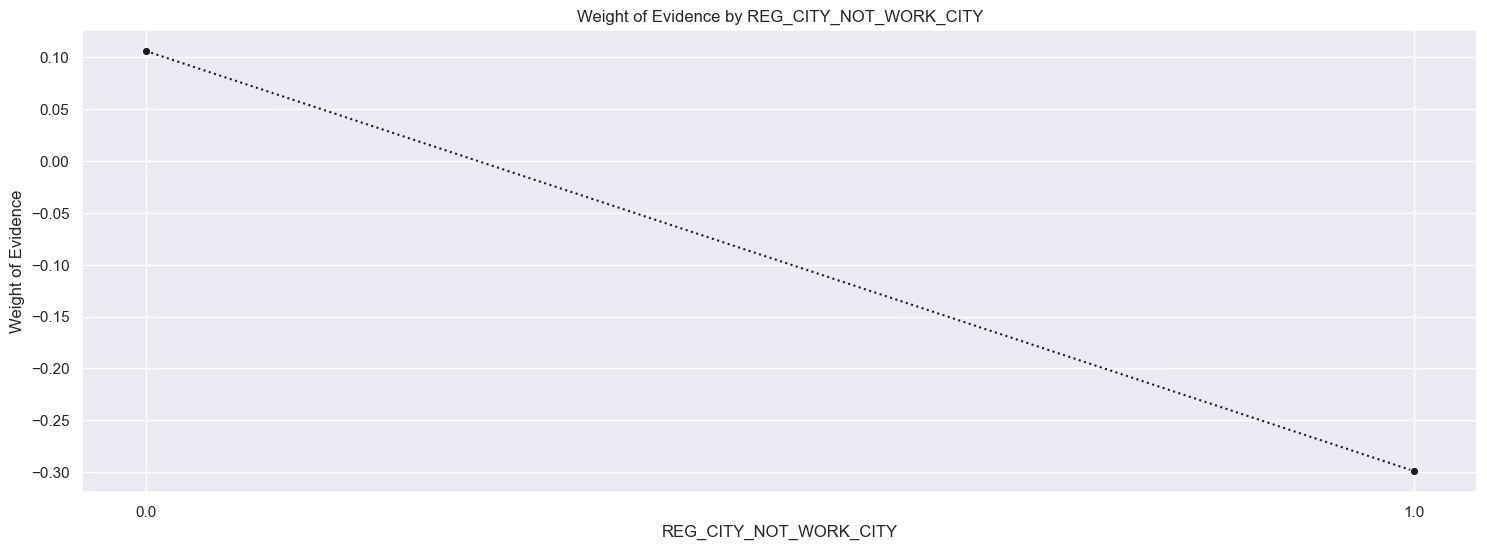

,REG_CITY_NOT_WORK_CITY,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,189329,0.926805,0.769605,175471.0,13858.0,0.775912,0.697784,0.106129,NaN,NaN,0.03166
1,1.0,56679,0.894105,0.230395,50677.0,6002.0,0.224088,0.302216,-0.299103,0.032699,0.405232,0.03166


In [40]:
woe_ordered_continuous(X_train, 'REG_CITY_NOT_WORK_CITY', y_train)

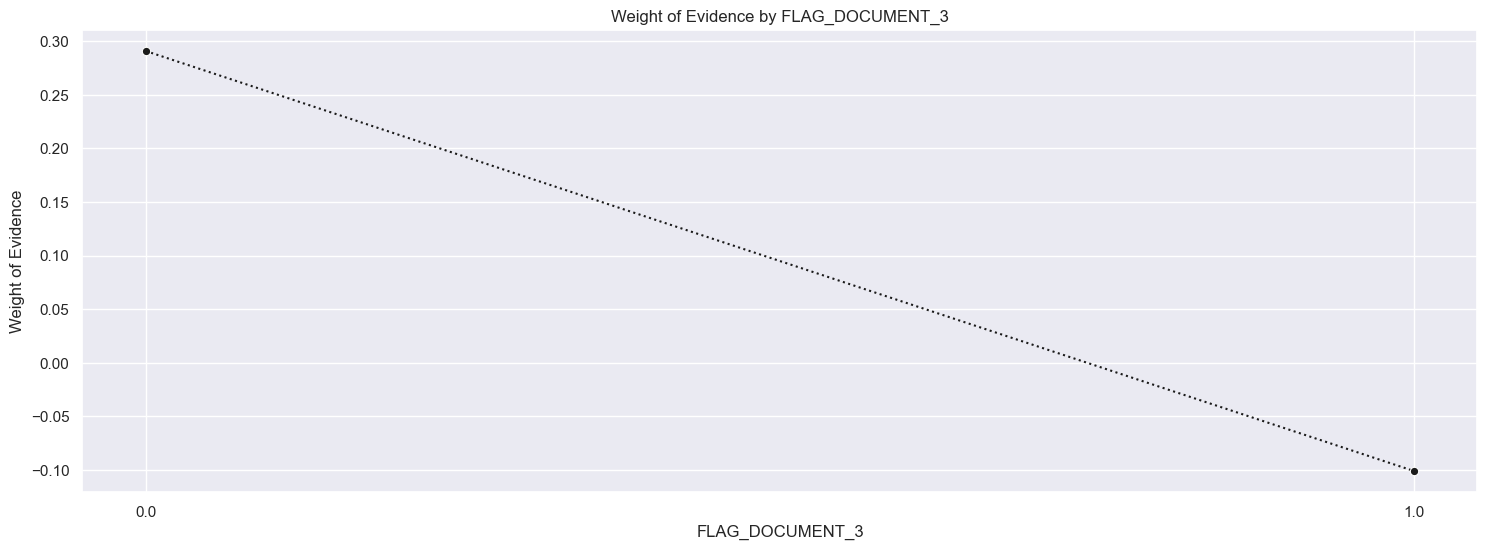

,FLAG_DOCUMENT_3,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,71435,0.938392,0.290377,67034.0,4401.0,0.296417,0.221601,0.290886,NaN,NaN,0.029323
1,1.0,174573,0.911447,0.709623,159114.0,15459.0,0.703583,0.778399,-0.101052,0.026945,0.391939,0.029323


In [41]:
woe_ordered_continuous(X_train, 'FLAG_DOCUMENT_3', y_train)

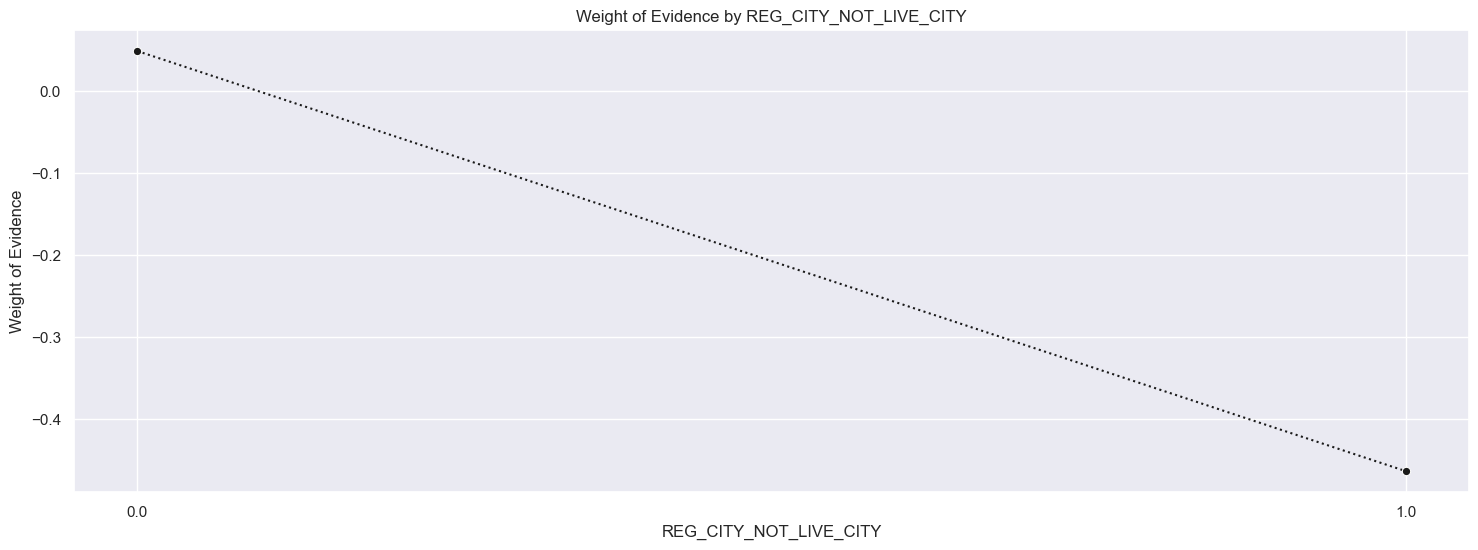

,REG_CITY_NOT_LIVE_CITY,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,226815,0.922805,0.921982,209306.0,17509.0,0.925527,0.881621,0.048600,NaN,NaN,0.022482
1,1.0,19193,0.877507,0.078018,16842.0,2351.0,0.074473,0.118379,-0.463447,0.045298,0.512047,0.022482


In [42]:
woe_ordered_continuous(X_train, 'REG_CITY_NOT_LIVE_CITY', y_train)

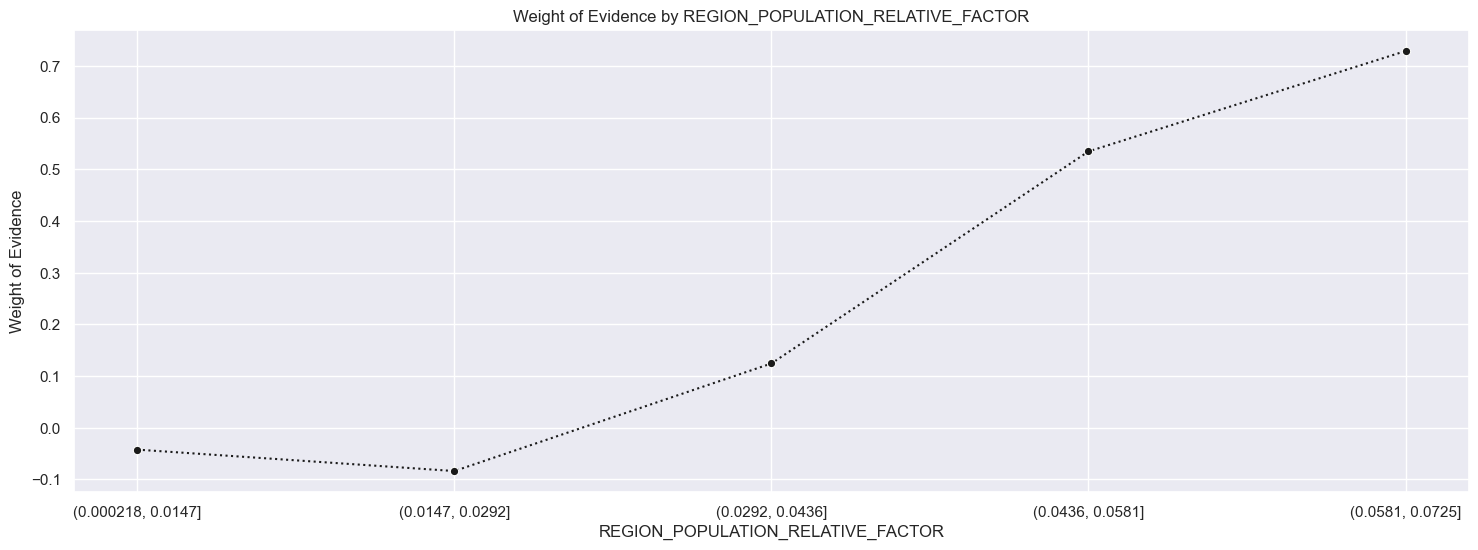

,REGION_POPULATION_RELATIVE_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.000218, 0.0147]",90449,0.916074,0.367667,82858.0,7591.0,0.366388,0.382226,-0.042317,NaN,NaN,0.026641
1,"(0.0147, 0.0292]",100843,0.912835,0.409918,92053.0,8790.0,0.407048,0.442598,-0.083732,0.003239,0.041415,0.026641
2,"(0.0292, 0.0436]",37197,0.928032,0.151202,34520.0,2677.0,0.152643,0.134794,0.124360,0.015197,0.208092,0.026641
3,"(0.0436, 0.0581]",10829,0.951057,0.044019,10299.0,530.0,0.045541,0.026687,0.534443,0.023026,0.410083,0.026641
4,"(0.0581, 0.0725]",6690,0.959342,0.027194,6418.0,272.0,0.028380,0.013696,0.728578,0.008285,0.194135,0.026641


In [43]:
# Fine classing of 5 bins - applied to all continuous variables with high cardinality.
X_train['REGION_POPULATION_RELATIVE_FACTOR'] = pd.cut(X_train['REGION_POPULATION_RELATIVE'], 5)
woe_ordered_continuous(X_train, 'REGION_POPULATION_RELATIVE_FACTOR', y_train)

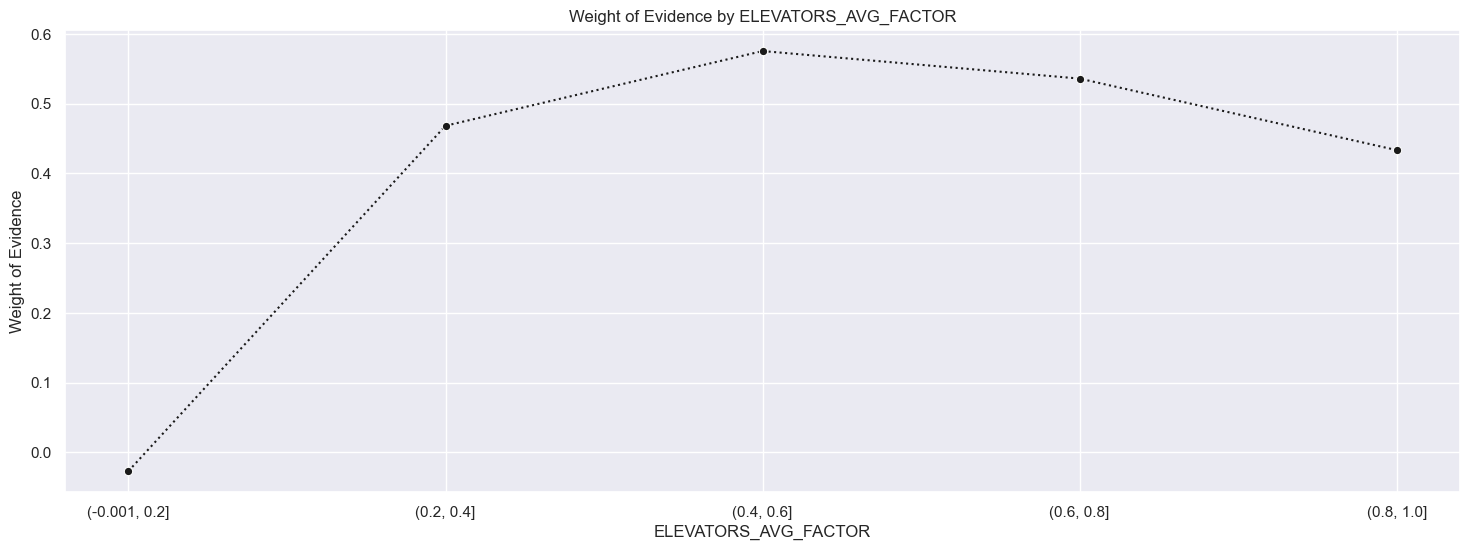

,ELEVATORS_AVG_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 0.2]",230259,0.917254,0.935982,211206.0,19053.0,0.933928,0.959366,-0.026873,NaN,NaN,0.013133
1,"(0.2, 0.4]",12337,0.947880,0.050149,11694.0,643.0,0.051709,0.032377,0.468204,0.030626,0.495077,0.013133
2,"(0.4, 0.6]",2358,0.952926,0.009585,2247.0,111.0,0.009936,0.005589,0.575339,0.005046,0.107135,0.013133
3,"(0.6, 0.8]",757,0.951123,0.003077,720.0,37.0,0.003184,0.001863,0.535851,0.001803,0.039488,0.013133
4,"(0.8, 1.0]",297,0.946128,0.001207,281.0,16.0,0.001243,0.000806,0.433284,0.004995,0.102567,0.013133


In [44]:
X_train['ELEVATORS_AVG_FACTOR'] = pd.cut(X_train['ELEVATORS_AVG'], 5)
woe_ordered_continuous(X_train, 'ELEVATORS_AVG_FACTOR', y_train)

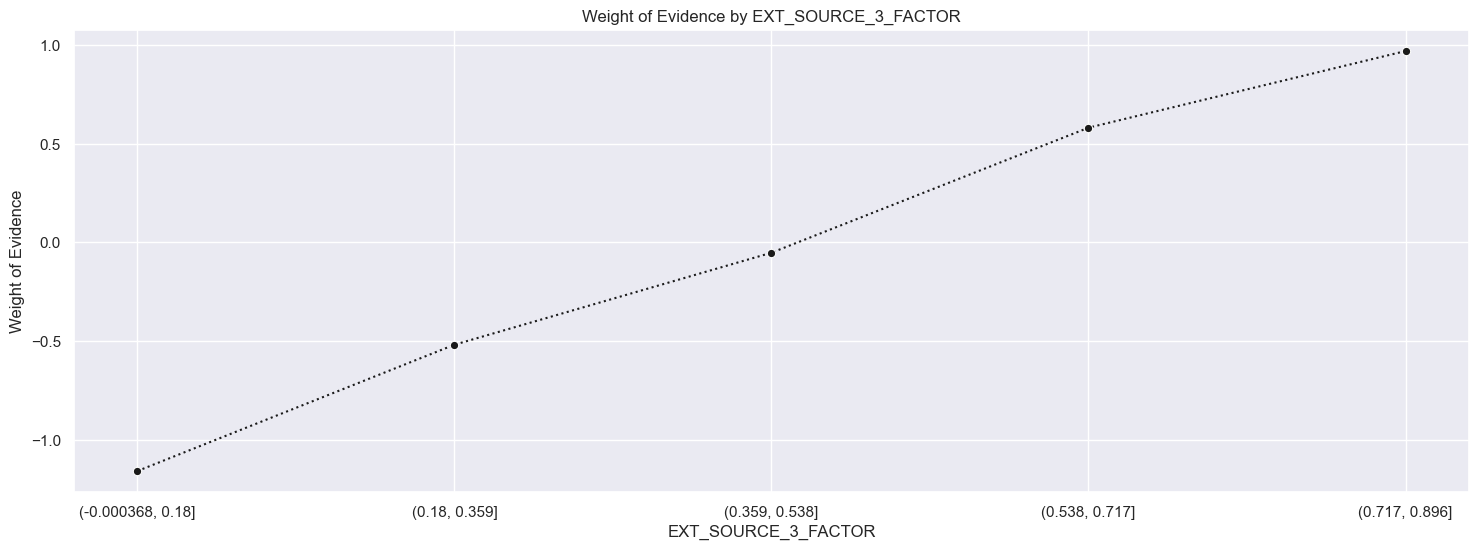

,EXT_SOURCE_3_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.000368, 0.18]",12866,0.781595,0.052299,10056.0,2810.0,0.044466,0.141490,-1.157497,NaN,NaN,0.309801
1,"(0.18, 0.359]",33277,0.871533,0.135268,29002.0,4275.0,0.128243,0.215257,-0.517901,0.089938,0.639596,0.309801
2,"(0.359, 0.538]",102013,0.915315,0.414674,93374.0,8639.0,0.412889,0.434995,-0.052156,0.043782,0.465745,0.309801
3,"(0.538, 0.717]",67248,0.953173,0.273357,64099.0,3149.0,0.283438,0.158560,0.580862,0.037859,0.633018,0.309801
4,"(0.717, 0.896]",30604,0.967749,0.124402,29617.0,987.0,0.130963,0.049698,0.968952,0.014576,0.388090,0.309801


In [45]:
X_train['EXT_SOURCE_3_FACTOR'] = pd.cut(X_train['EXT_SOURCE_3'], 5)
woe_ordered_continuous(X_train, 'EXT_SOURCE_3_FACTOR', y_train)

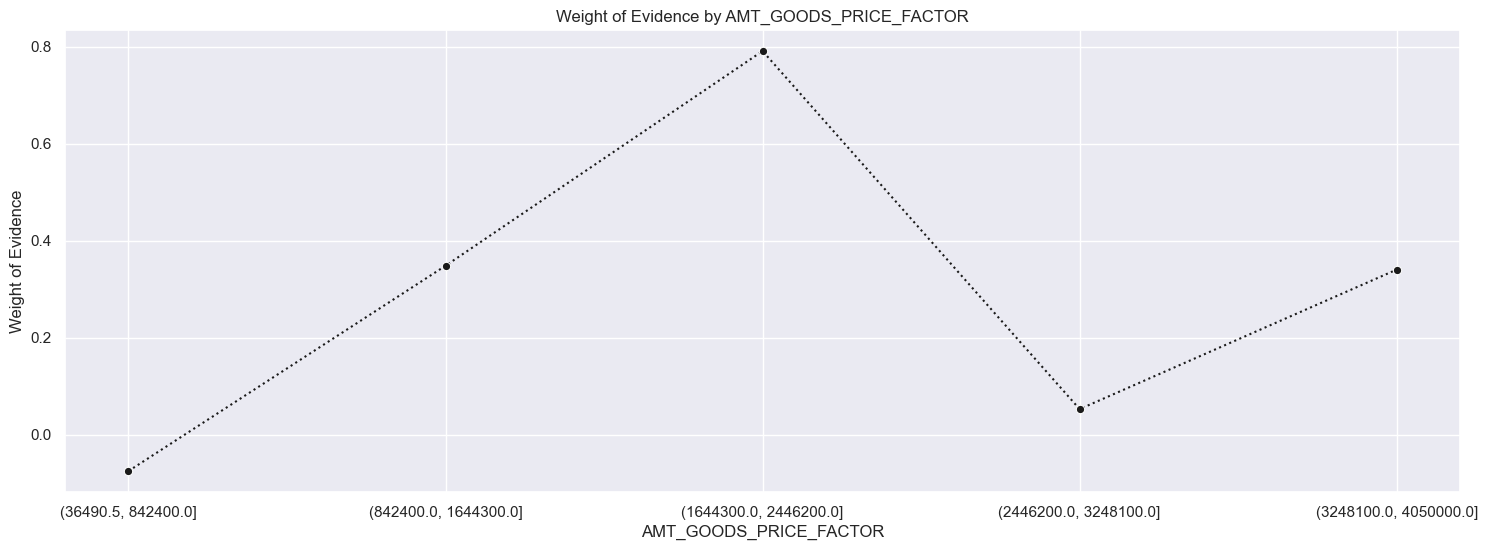

,AMT_GOODS_PRICE_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(36490.5, 842400.0]",197831,0.913502,0.804165,180719.0,17112.0,0.799118,0.861631,-0.075319,NaN,NaN,0.029823
1,"(842400.0, 1644300.0]",44857,0.941614,0.182340,42238.0,2619.0,0.186771,0.131873,0.348046,0.028113,0.423364,0.029823
2,"(1644300.0, 2446200.0]",3264,0.961703,0.013268,3139.0,125.0,0.013880,0.006294,0.790864,0.020089,0.442818,0.029823
3,"(2446200.0, 3248100.0]",39,0.923077,0.000159,36.0,3.0,0.000159,0.000151,0.052425,0.038627,0.738439,0.029823
4,"(3248100.0, 4050000.0]",17,0.941176,0.000069,16.0,1.0,0.000071,0.000050,0.340107,0.018100,0.287682,0.029823


In [46]:
X_train['AMT_GOODS_PRICE_FACTOR'] = pd.cut(X_train['AMT_GOODS_PRICE'], 5)
woe_ordered_continuous(X_train, 'AMT_GOODS_PRICE_FACTOR', y_train)

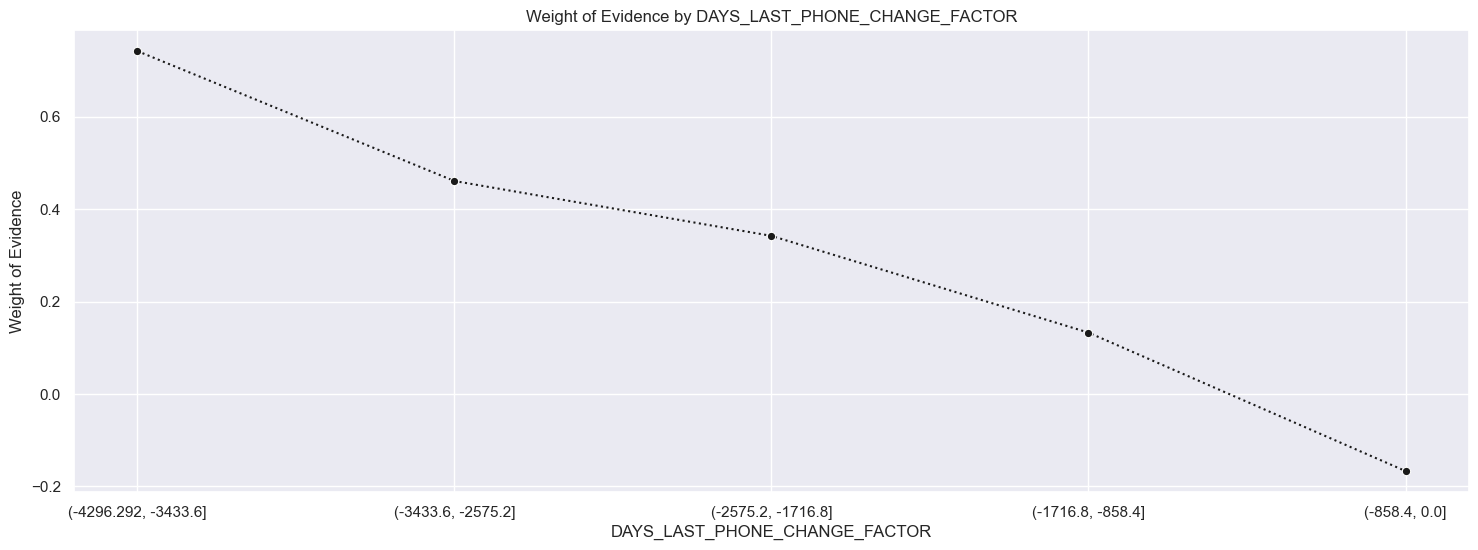

,DAYS_LAST_PHONE_CHANGE_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-4296.292, -3433.6]",548,0.959854,0.002228,526.0,22.0,0.002326,0.001108,0.741777,NaN,NaN,0.044514
1,"(-3433.6, -2575.2]",10135,0.947509,0.041198,9603.0,532.0,0.042463,0.026788,0.460705,0.012345,0.281071,0.044514
2,"(-2575.2, -1716.8]",38830,0.941283,0.157840,36550.0,2280.0,0.161620,0.114804,0.342024,0.006226,0.118682,0.044514
3,"(-1716.8, -858.4]",63860,0.928594,0.259585,59300.0,4560.0,0.262218,0.229607,0.132805,0.012689,0.209219,0.044514
4,"(-858.4, 0.0]",132635,0.906013,0.539149,120169.0,12466.0,0.531373,0.627694,-0.166588,0.022581,0.299393,0.044514


In [47]:
X_train['DAYS_LAST_PHONE_CHANGE_FACTOR'] = pd.cut(X_train['DAYS_LAST_PHONE_CHANGE'], 5)
woe_ordered_continuous(X_train, 'DAYS_LAST_PHONE_CHANGE_FACTOR', y_train)

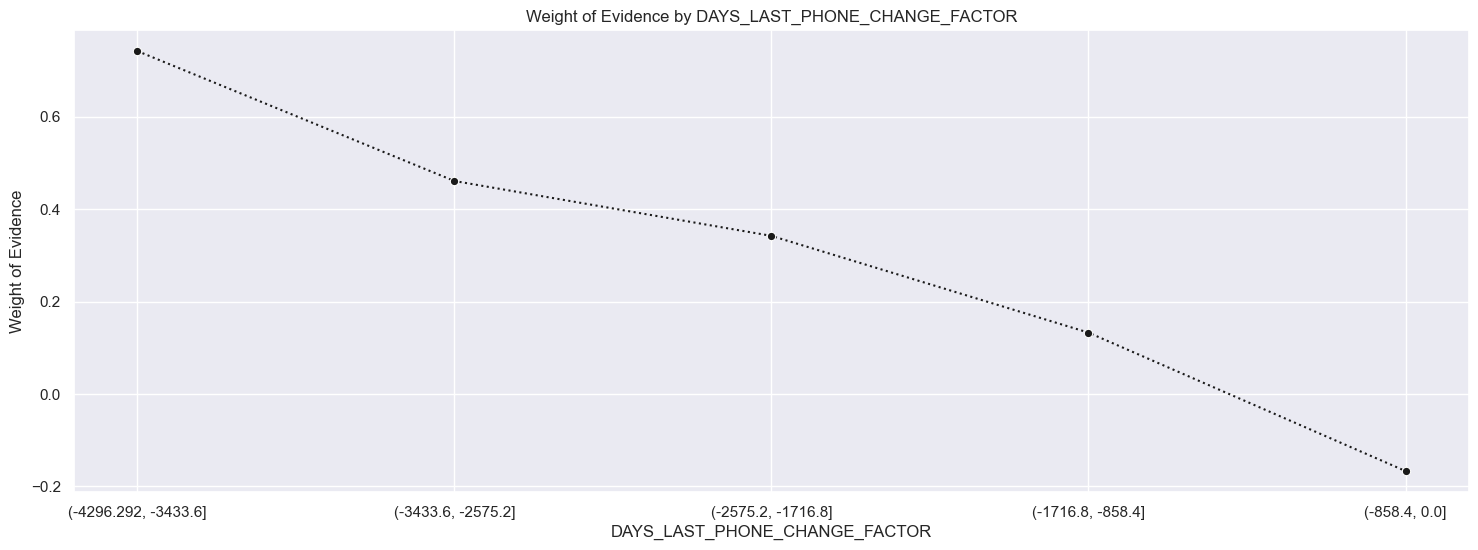

,DAYS_LAST_PHONE_CHANGE_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-4296.292, -3433.6]",548,0.959854,0.002228,526.0,22.0,0.002326,0.001108,0.741777,NaN,NaN,0.044514
1,"(-3433.6, -2575.2]",10135,0.947509,0.041198,9603.0,532.0,0.042463,0.026788,0.460705,0.012345,0.281071,0.044514
2,"(-2575.2, -1716.8]",38830,0.941283,0.157840,36550.0,2280.0,0.161620,0.114804,0.342024,0.006226,0.118682,0.044514
3,"(-1716.8, -858.4]",63860,0.928594,0.259585,59300.0,4560.0,0.262218,0.229607,0.132805,0.012689,0.209219,0.044514
4,"(-858.4, 0.0]",132635,0.906013,0.539149,120169.0,12466.0,0.531373,0.627694,-0.166588,0.022581,0.299393,0.044514


In [48]:
X_train['DAYS_LAST_PHONE_CHANGE_FACTOR'] = pd.cut(X_train['DAYS_LAST_PHONE_CHANGE'], 5)
woe_ordered_continuous(X_train, 'DAYS_LAST_PHONE_CHANGE_FACTOR', y_train)

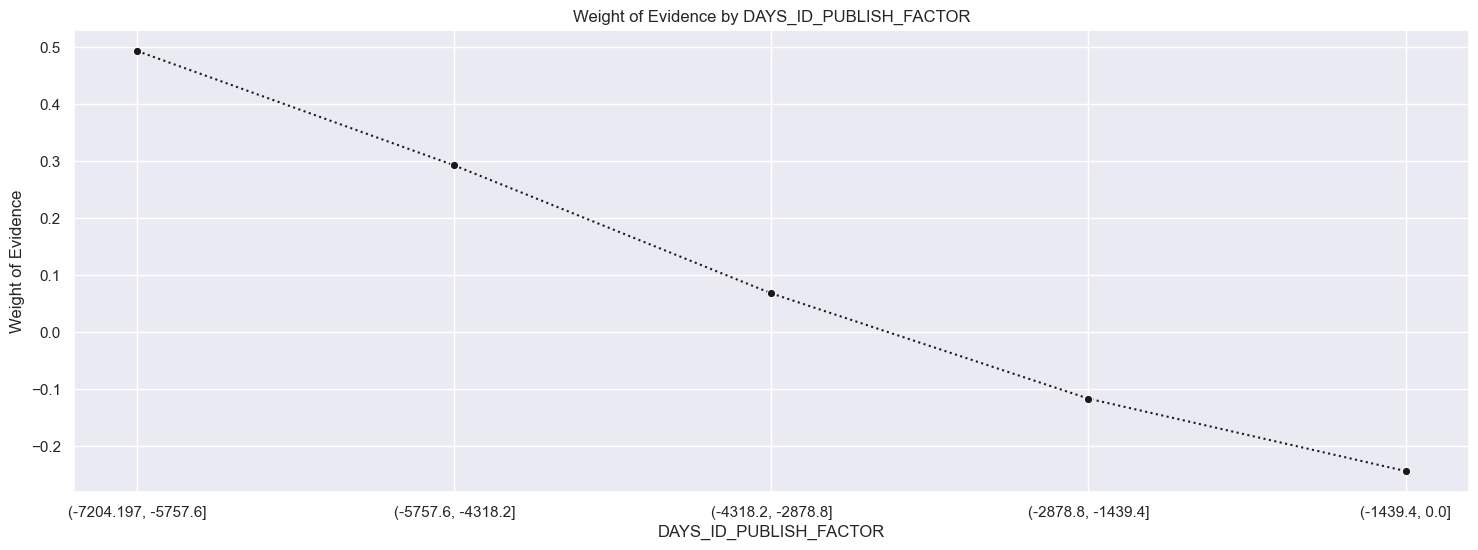

,DAYS_ID_PUBLISH_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7204.197, -5757.6]",903,0.949059,0.003671,857.0,46.0,0.003790,0.002316,0.492315,NaN,NaN,0.037123
1,"(-5757.6, -4318.2]",58689,0.938455,0.238565,55077.0,3612.0,0.243544,0.181873,0.291989,0.010603,0.200326,0.037123
2,"(-4318.2, -2878.8]",78789,0.924165,0.320270,72814.0,5975.0,0.321975,0.300856,0.067842,0.014291,0.224146,0.037123
3,"(-2878.8, -1439.4]",56158,0.910200,0.228277,51115.0,5043.0,0.226025,0.253927,-0.116405,0.013965,0.184247,0.037123
4,"(-1439.4, 0.0]",51469,0.899279,0.209217,46285.0,5184.0,0.204667,0.261027,-0.243241,0.010921,0.126836,0.037123


In [49]:
X_train['DAYS_ID_PUBLISH_FACTOR'] = pd.cut(X_train['DAYS_ID_PUBLISH'], 5)
woe_ordered_continuous(X_train, 'DAYS_ID_PUBLISH_FACTOR', y_train)

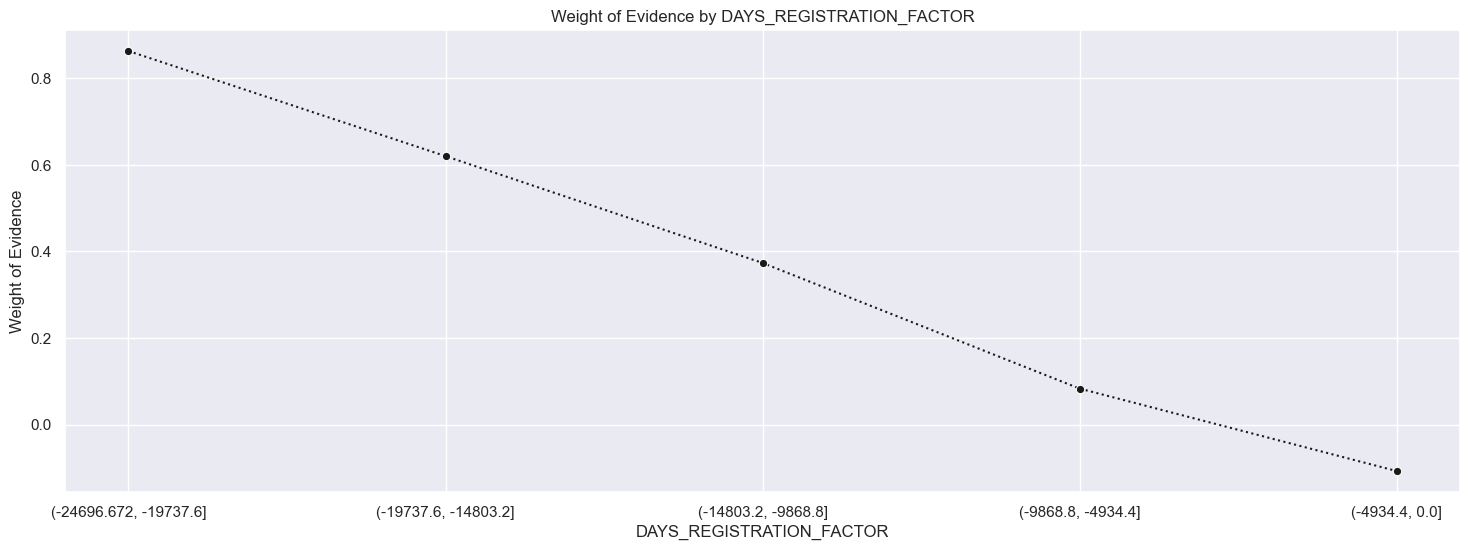

,DAYS_REGISTRATION_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-24696.672, -19737.6]",28,0.964286,0.000114,27.0,1.0,0.000119,0.000050,0.863355,NaN,NaN,0.022183
1,"(-19737.6, -14803.2]",1131,0.954907,0.004597,1080.0,51.0,0.004776,0.002568,0.620409,0.009379,0.242946,0.022183
2,"(-14803.2, -9868.8]",24297,0.942997,0.098765,22912.0,1385.0,0.101314,0.069738,0.373479,0.011910,0.246930,0.022183
3,"(-9868.8, -4934.4]",85538,0.925226,0.347704,79142.0,6396.0,0.349957,0.322054,0.083089,0.017771,0.290390,0.022183
4,"(-4934.4, 0.0]",135014,0.910920,0.548820,122987.0,12027.0,0.543834,0.605589,-0.107557,0.014306,0.190646,0.022183


In [50]:
X_train['DAYS_REGISTRATION_FACTOR'] = pd.cut(X_train['DAYS_REGISTRATION'], 5)
woe_ordered_continuous(X_train, 'DAYS_REGISTRATION_FACTOR', y_train)

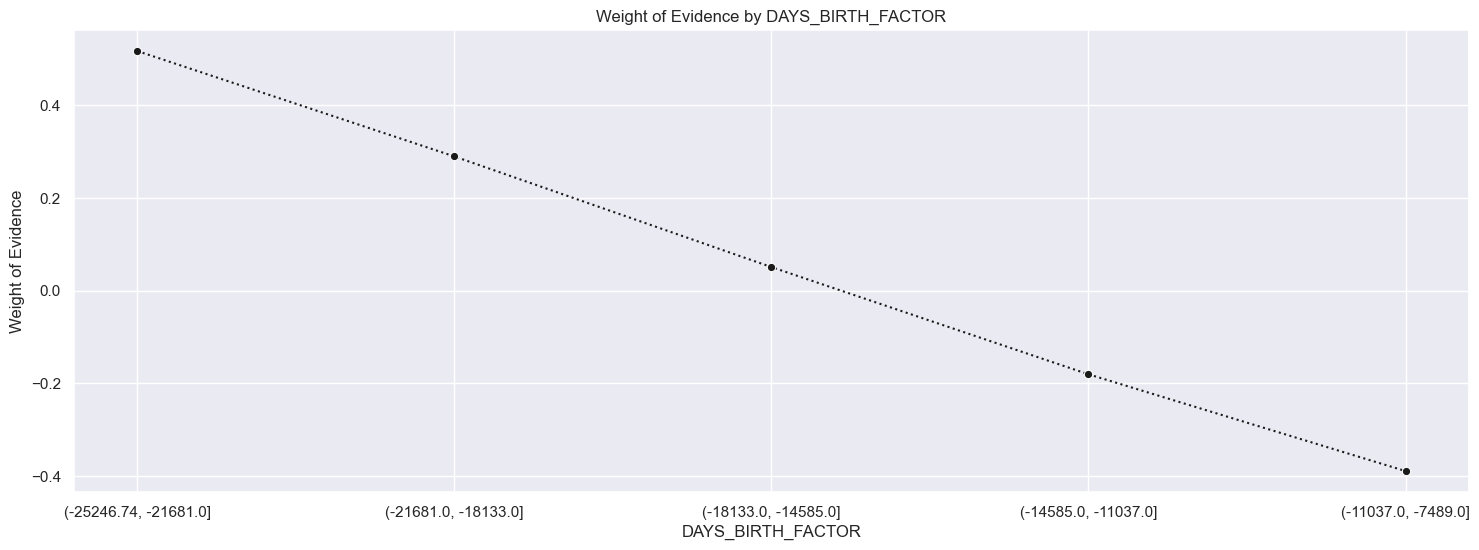

,DAYS_BIRTH_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-25246.74, -21681.0]",31533,0.950179,0.128179,29962.0,1571.0,0.132488,0.079104,0.515736,NaN,NaN,0.080249
1,"(-21681.0, -18133.0]",52875,0.938270,0.214932,49611.0,3264.0,0.219374,0.164350,0.288777,0.011910,0.226958,0.080249
2,"(-18133.0, -14585.0]",59875,0.922939,0.243386,55261.0,4614.0,0.244358,0.232326,0.050490,0.015330,0.238287,0.080249
3,"(-14585.0, -11037.0]",64318,0.904832,0.261447,58197.0,6121.0,0.257340,0.308207,-0.180374,0.018107,0.230864,0.080249
4,"(-11037.0, -7489.0]",37407,0.885316,0.152056,33117.0,4290.0,0.146439,0.216012,-0.388722,0.019517,0.208348,0.080249


In [51]:
X_train['DAYS_BIRTH_FACTOR'] = pd.cut(X_train['DAYS_BIRTH'], 5)
woe_ordered_continuous(X_train, 'DAYS_BIRTH_FACTOR', y_train)

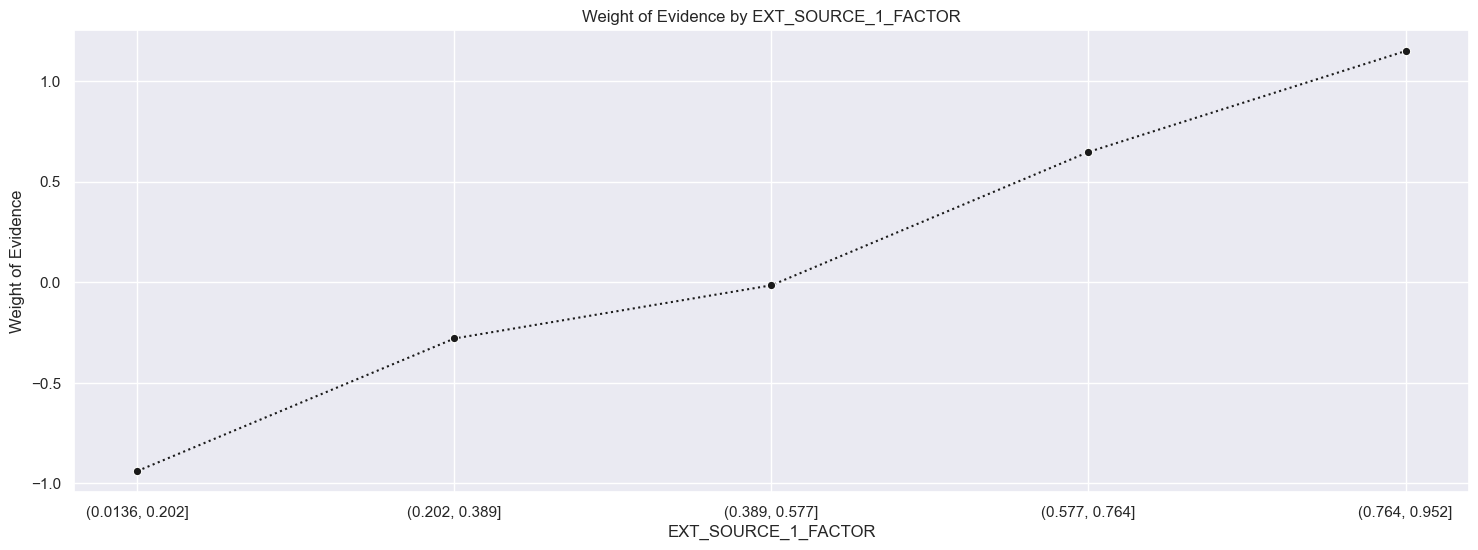

,EXT_SOURCE_1_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.0136, 0.202]",9539,0.816647,0.038775,7790.0,1749.0,0.034446,0.088066,-0.938685,NaN,NaN,0.142667
1,"(0.202, 0.389]",25802,0.895900,0.104883,23116.0,2686.0,0.102216,0.135247,-0.280010,0.079252,0.658675,0.142667
2,"(0.389, 0.577]",168463,0.918101,0.684787,154666.0,13797.0,0.683915,0.694713,-0.015665,0.022201,0.264345,0.142667
3,"(0.577, 0.764]",28699,0.956026,0.116659,27437.0,1262.0,0.121323,0.063545,0.646713,0.037926,0.662378,0.142667
4,"(0.764, 0.952]",13505,0.972899,0.054897,13139.0,366.0,0.058099,0.018429,1.148225,0.016873,0.501512,0.142667


In [52]:
X_train['EXT_SOURCE_1_FACTOR'] = pd.cut(X_train['EXT_SOURCE_1'], 5)
woe_ordered_continuous(X_train, 'EXT_SOURCE_1_FACTOR', y_train)

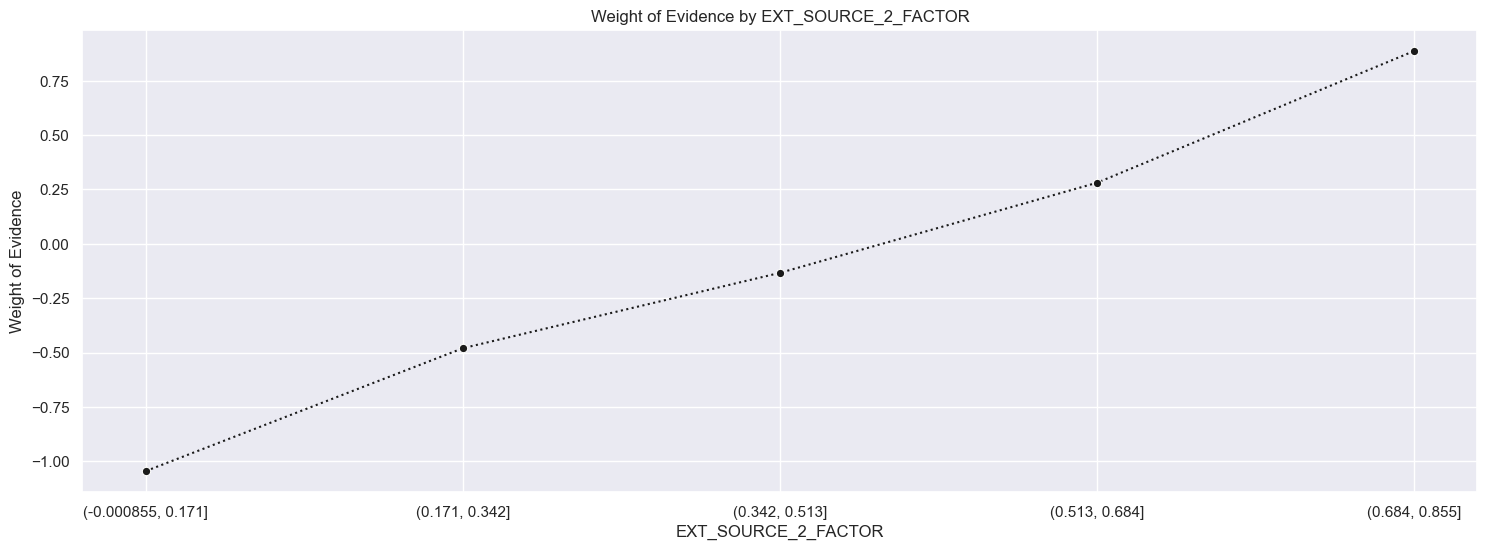

,EXT_SOURCE_2_FACTOR,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.000855, 0.171]",17963,0.800200,0.073018,14374.0,3589.0,0.063560,0.180715,-1.044935,NaN,NaN,0.297108
1,"(0.171, 0.342]",31690,0.875702,0.128817,27751.0,3939.0,0.122712,0.198338,-0.480137,0.075502,0.564798,0.297108
2,"(0.342, 0.513]",48978,0.908775,0.199091,44510.0,4468.0,0.196818,0.224975,-0.133709,0.033073,0.346428,0.297108
3,"(0.513, 0.684]",99553,0.937792,0.404674,93360.0,6193.0,0.412827,0.311833,0.280561,0.029017,0.414270,0.297108
4,"(0.684, 0.855]",47824,0.965059,0.194400,46153.0,1671.0,0.204083,0.084139,0.886058,0.027267,0.605496,0.297108


In [53]:
X_train['EXT_SOURCE_2_FACTOR'] = pd.cut(X_train['EXT_SOURCE_2'], 5)
woe_ordered_continuous(X_train, 'EXT_SOURCE_2_FACTOR', y_train)

In [54]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        # Categorical features
        X_new = X.loc[:, 'CODE_GENDER:M'].to_frame()
        X_new['CODE_GENDER:F'] = X.loc[:,'CODE_GENDER:F']

        X_new['NAME_EDUCATION_TYPE:Academic degree'] = X.loc[:,'NAME_EDUCATION_TYPE:Academic degree']
        X_new['NAME_EDUCATION_TYPE:Higher education'] = X.loc[:,'NAME_EDUCATION_TYPE:Higher education']
        X_new['NAME_EDUCATION_TYPE:Incomplete higher'] = X.loc[:,'NAME_EDUCATION_TYPE:Incomplete higher']
        X_new['NAME_EDUCATION_TYPE:Lower secondary'] = X.loc[:,'NAME_EDUCATION_TYPE:Lower secondary']
        X_new['NAME_EDUCATION_TYPE:Secondary / secondary special'] = X.loc[:,'NAME_EDUCATION_TYPE:Secondary / secondary special']

        X_new['NAME_FAMILY_STATUS:Single / not married'] = X.loc[:,'NAME_FAMILY_STATUS:Single / not married']
        X_new['NAME_FAMILY_STATUS:Civil marriage'] = X.loc[:,'NAME_FAMILY_STATUS:Civil marriage']
        X_new['NAME_FAMILY_STATUS:Married'] = X.loc[:,'NAME_FAMILY_STATUS:Married']
        X_new['NAME_FAMILY_STATUS:Separated'] = X.loc[:,'NAME_FAMILY_STATUS:Separated']
        X_new['NAME_FAMILY_STATUS:Widow'] = X.loc[:,'NAME_FAMILY_STATUS:Widow']

        X_new['NAME_INCOME_TYPE:Commercial_Associate'] = X.loc[:,'NAME_INCOME_TYPE:Commercial associate']
        X_new['NAME_INCOME_TYPE:Pensioner'] = X.loc[:,'NAME_INCOME_TYPE:Pensioner']
        X_new['NAME_INCOME_TYPE:Unemployed'] = X.loc[:,'NAME_INCOME_TYPE:Unemployed']
        X_new['NAME_INCOME_TYPE:State servant'] = X.loc[:,'NAME_INCOME_TYPE:State servant']
        X_new['NAME_INCOME_TYPE:Working'] = X.loc[:,'NAME_INCOME_TYPE:Working']
        
        # Numerical features
        X_new['REG_CITY_NOT_WORK_CITY:0'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 0), 1, 0)
        X_new['REG_CITY_NOT_WORK_CITY:1'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 1), 1, 0)

        X_new['FLAG_DOCUMENT_3:0'] = np.where((X['FLAG_DOCUMENT_3'] == 0), 1, 0)
        X_new['FLAG_DOCUMENT_3:1'] = np.where((X['FLAG_DOCUMENT_3'] == 1), 1, 0)

        X_new['REG_CITY_NOT_LIVE_CITY:0'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 0), 1, 0)
        X_new['REG_CITY_NOT_LIVE_CITY:1'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 1), 1, 0)

        X_new['REGION_POPULATION_RELATIVE:Under 0.0147'] = np.where((X['REGION_POPULATION_RELATIVE'] < 0.0147), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0148-0.0292'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0147) & 
                                                                     (X['REGION_POPULATION_RELATIVE'] <= 0.0292), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0292-0.0436'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0292) & 
                                                                     (X['REGION_POPULATION_RELATIVE'] <= 0.0436), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0436-0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0436) & 
                                                                     (X['REGION_POPULATION_RELATIVE'] <= 0.0581), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:Above 0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0581), 1, 0)
        
        X_new['ELEVATORS_AVG:Under 0.2'] = np.where((X['ELEVATORS_AVG'] <= 0.2), 1, 0)
        X_new['ELEVATORS_AVG:0.2-0.4'] = np.where((X['ELEVATORS_AVG'] > 0.2) &
                                                  (X['ELEVATORS_AVG'] <= 0.4), 1, 0)
        X_new['ELEVATORS_AVG:0.4-0.6'] = np.where((X['ELEVATORS_AVG'] > 0.4) &
                                                  (X['ELEVATORS_AVG'] <= 0.6), 1, 0)
        X_new['ELEVATORS_AVG:0.6-0.8'] = np.where((X['ELEVATORS_AVG'] > 0.6) &
                                                  (X['ELEVATORS_AVG'] <= 0.8), 1, 0)
        X_new['ELEVATORS_AVG:0.8-1.0'] = np.where((X['ELEVATORS_AVG'] > 0.8), 1, 0)
        
        X_new['EXT_SOURCE_3:Under 0.18'] = np.where((X['EXT_SOURCE_3'] < 0.18), 1, 0)
        X_new['EXT_SOURCE_3:0.18-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.18) & 
                                                    (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3:0.359-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.359) & 
                                                     (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3:0.538-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.538) & 
                                                     (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3:Above 0.717'] = np.where((X['EXT_SOURCE_3'] > 0.717), 1, 0)
        
        X_new['EXT_SOURCE_3:Under 0.18'] = np.where((X['EXT_SOURCE_3'] < 0.18), 1, 0)
        X_new['EXT_SOURCE_3:0.18-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.18) & 
                                                    (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3:0.359-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.359) & 
                                                     (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3:0.538-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.538) & 
                                                     (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3:Above 0.717'] = np.where((X['EXT_SOURCE_3'] > 0.717), 1, 0)

        X_new['AMT_GOODS_PRICE:Under 842400'] = np.where((X['AMT_GOODS_PRICE'] < 842400), 1, 0)
        X_new['AMT_GOODS_PRICE:842400-1644300'] = np.where((X['AMT_GOODS_PRICE'] > 842400) & 
                                                           (X['AMT_GOODS_PRICE'] <= 1644300), 1, 0)
        X_new['AMT_GOODS_PRICE:1644300-2446200'] = np.where((X['AMT_GOODS_PRICE'] > 1644300) & 
                                                            (X['AMT_GOODS_PRICE'] <= 2446200), 1, 0)
        X_new['AMT_GOODS_PRICE:2446200-3248100'] = np.where((X['AMT_GOODS_PRICE'] > 2446200) & 
                                                            (X['AMT_GOODS_PRICE'] <= 3248100), 1, 0)
        X_new['AMT_GOODS_PRICE Above 3248100'] = np.where((X['AMT_GOODS_PRICE'] > 3248100), 1, 0)
       
        X_new['DAYS_LAST_PHONE_CHANGE:Above 3433.6'] = np.where((X['DAYS_LAST_PHONE_CHANGE'] < -3433.6), 1, 0)
        X_new['DAYS_LAST_PHONE_CHANGE:3433.6-2575.2'] = np.where((X['DAYS_LAST_PHONE_CHANGE'] > -3433.6) & 
                                                                  (X['DAYS_LAST_PHONE_CHANGE'] <= -2575.2), 1, 0)
        X_new['DAYS_LAST_PHONE_CHANGE:2575.2-1716.8'] = np.where((X['DAYS_LAST_PHONE_CHANGE'] > -2575.2) & 
                                                                  (X['DAYS_LAST_PHONE_CHANGE'] <= -1716.8), 1, 0)
        X_new['DAYS_LAST_PHONE_CHANGE:1716.8-858.4'] = np.where((X['DAYS_LAST_PHONE_CHANGE'] > -1716.8) & 
                                                                  (X['DAYS_LAST_PHONE_CHANGE'] <= -858.4), 1, 0)
        X_new['DAYS_LAST_PHONE_CHANGE: Under 858.4'] = np.where((X['DAYS_LAST_PHONE_CHANGE'] > -858.4), 1, 0)
        
        X_new['DAYS_ID_PUBLISH:Above 19737.6'] = np.where((X['DAYS_ID_PUBLISH'] < -19737.6), 1, 0)
        X_new['DAYS_ID_PUBLISH:19737.6-14803.2'] = np.where((X['DAYS_ID_PUBLISH'] > -19737.6) & 
                                                          (X['DAYS_ID_PUBLISH'] <= -14803.2), 1, 0)
        X_new['DAYS_ID_PUBLISH:14803.2-9868.8'] = np.where((X['DAYS_ID_PUBLISH'] > -14803.2) & 
                                                          (X['DAYS_ID_PUBLISH'] <= -9868.8), 1, 0)
        X_new['DAYS_ID_PUBLISH:9868.8-4934.4'] = np.where((X['DAYS_ID_PUBLISH'] > -9868.8) & 
                                                          (X['DAYS_ID_PUBLISH'] <= -4934.4), 1, 0)
        X_new['DAYS_ID_PUBLISH:Under 4934.4'] = np.where((X['DAYS_ID_PUBLISH'] > -4934.4), 1, 0)

        X_new['DAYS_REGISTRATION:Above 24696.672'] = np.where((X['DAYS_REGISTRATION'] < -24696.672), 1, 0)
        X_new['DAYS_REGISTRATION:24696.672-2575.2'] = np.where((X['DAYS_REGISTRATION'] > -3433.6) & 
                                                            (X['DAYS_REGISTRATION'] <= -2575.2), 1, 0)
        X_new['DAYS_REGISTRATION:2575.2-1716.8'] = np.where((X['DAYS_REGISTRATION'] > -2575.2) & 
                                                            (X['DAYS_REGISTRATION'] <= -1716.8), 1, 0)
        X_new['DAYS_REGISTRATION:1716.8-858.4'] = np.where((X['DAYS_REGISTRATION'] > -1716.8) & 
                                                           (X['DAYS_REGISTRATION'] <= -858.4), 1, 0)
        X_new['DAYS_REGISTRATION:Under 858.4'] = np.where((X['DAYS_REGISTRATION'] > -858.4), 1, 0)

        X_new['DAYS_BIRTH:Above 21681.0'] = np.where((X['DAYS_BIRTH'] < -21681.0), 1, 0)
        X_new['DAYS_BIRTH:21681.0-18133.0'] = np.where((X['DAYS_BIRTH'] > -21681.0) & 
                                                     (X['DAYS_BIRTH'] <= -18133.0), 1, 0)
        X_new['DAYS_BIRTH:18133.0-14585.0'] = np.where((X['DAYS_BIRTH'] > -14585.0) & 
                                                     (X['DAYS_BIRTH'] <= -1716.8), 1, 0)
        X_new['DAYS_BIRTH:14585.0-11037.0'] = np.where((X['DAYS_BIRTH'] > -14585.0) & 
                                                    (X['DAYS_BIRTH'] <= -11037.0), 1, 0)
        X_new['DAYS_BIRTH: Under 11037.0'] = np.where((X['DAYS_BIRTH'] > -11037.0), 1, 0)
        
        X_new['EXT_SOURCE_1:Under 0.202'] = np.where((X['EXT_SOURCE_1'] < 0.202), 1, 0)
        X_new['EXT_SOURCE_1:0.202-0.389'] = np.where((X['EXT_SOURCE_1'] > 0.202) & 
                                                    (X['EXT_SOURCE_1'] <= 0.389), 1, 0)
        X_new['EXT_SOURCE_1:0.389-0.577'] = np.where((X['EXT_SOURCE_1'] > 0.389) & 
                                                     (X['EXT_SOURCE_1'] <= 0.577), 1, 0)
        X_new['EXT_SOURCE_1:0.577-0.764'] = np.where((X['EXT_SOURCE_1'] > 0.577) & 
                                                     (X['EXT_SOURCE_1'] <= 0.764), 1, 0)
        X_new['EXT_SOURCE_1:Above 0.764'] = np.where((X['EXT_SOURCE_1'] > 0.717), 1, 0)   \
        
        X_new['EXT_SOURCE_2:Under 0.171'] = np.where((X['EXT_SOURCE_2'] < 0.171), 1, 0)
        X_new['EXT_SOURCE_2:0.171-0.342'] = np.where((X['EXT_SOURCE_2'] > 0.171) & 
                                                    (X['EXT_SOURCE_2'] <= 0.342), 1, 0)
        X_new['EXT_SOURCE_2:0.342-0.513'] = np.where((X['EXT_SOURCE_2'] > 0.342) & 
                                                     (X['EXT_SOURCE_2'] <= 0.513), 1, 0)
        X_new['EXT_SOURCE_2:0.513-0.684'] = np.where((X['EXT_SOURCE_2'] > 0.513) & 
                                                     (X['EXT_SOURCE_2'] <= 0.684), 1, 0)
        X_new['EXT_SOURCE_2:Above 0.684'] = np.where((X['EXT_SOURCE_2'] > 0.684), 1, 0)
        
        return X_new

In [55]:
# Drop fine classing columns
fine_cols = ['REGION_POPULATION_RELATIVE_FACTOR', 'ELEVATORS_AVG_FACTOR', 'EXT_SOURCE_3_FACTOR', 'AMT_GOODS_PRICE_FACTOR',
             'DAYS_LAST_PHONE_CHANGE_FACTOR', 'DAYS_LAST_PHONE_CHANGE_FACTOR', 'DAYS_ID_PUBLISH_FACTOR',
             'DAYS_REGISTRATION_FACTOR', 'DAYS_BIRTH_FACTOR', 'EXT_SOURCE_1_FACTOR', 'EXT_SOURCE_2_FACTOR']
X_train = X_train.drop(columns=fine_cols)

# 6. Model Building

In [143]:
pd.DataFrame({'AUC Value': ['0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0'],
              'Variable Predictiveness' : ['Unsatisfactory','Satisfactory','Good','Very Good','Excellent']}).style.hide_index()

AUC Value,Variable Predictiveness
0.5 - 0.6,Unsatisfactory
0.6 - 0.7,Satisfactory
0.7 - 0.8,Good
0.8 - 0.9,Very Good
0.9 - 1.0,Excellent


### 6.1. XGBoost

In [56]:
from xgboost import XGBRegressor

# Define modelling pipeline
XGBReg = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4)
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', XGBReg)])

# Define cross-validation criteria. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Fit and evaluate the logistic regression pipeline
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# Print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7324
Gini: 0.4649


### 6.2. Logistic Regression (Preferred Model)

In [57]:
# Define modelling pipeline
LOGReg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', LOGReg)])

# Define cross-validation criteria. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Fit and evaluate the logistic regression pipeline
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# Print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7324
Gini: 0.4647


In [58]:
# Fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002         Cash loans           M            N   
1           100003         Cash loans           F            N   
2           100004    Revolving loans           M            Y   
3           100006         Cash loans           F            N   
4           100007         Cash loans           M            N   
...            ...                ...         ...          ...   
307506      456251         Cash loans           M            N   
307507      456252         Cash loans           F            N   
307508      456253         Cash loans           F            N   
307509      456254         Cash loans           F            N   
307510      456255         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOM...
307510                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  

In [59]:
# Create a summary table for logistic regression model
X_train_woe_transformed = woe_transform.fit_transform(X_train)
feature_name = X_train_woe_transformed.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.104028
1,CODE_GENDER:M,-0.101929
2,CODE_GENDER:F,0.188222
3,NAME_EDUCATION_TYPE:Academic degree,1.058300
4,NAME_EDUCATION_TYPE:Higher education,0.038668
...,...,...
69,EXT_SOURCE_2:Under 0.171,-0.756769
70,EXT_SOURCE_2:0.171-0.342,-0.282057
71,EXT_SOURCE_2:0.342-0.513,0.033356
72,EXT_SOURCE_2:0.513-0.684,0.333035


## 7. Model Evaluation

In [60]:
# Make preditions on test set
y_hat_test = pipeline.predict(X_test)

# Get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)

# Select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

# Create a new DF with actual classes and the predicted probabilities
# Create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']

# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
128081,1,0.637193
68695,1,0.472998
280602,1,0.546052
93006,1,0.326350
125876,1,0.370892


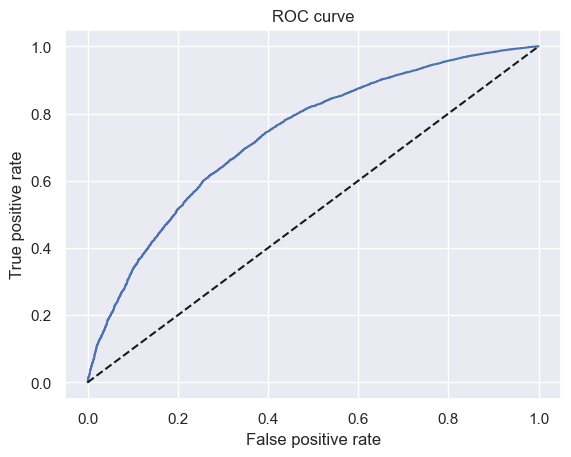

In [61]:
# Get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], 
                                 y_test_proba['y_hat_test_proba'])
# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [62]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# Calculate Gini from AUROC
Gini = AUROC * 2 - 1

print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

AUROC: 0.7333
Gini: 0.4666


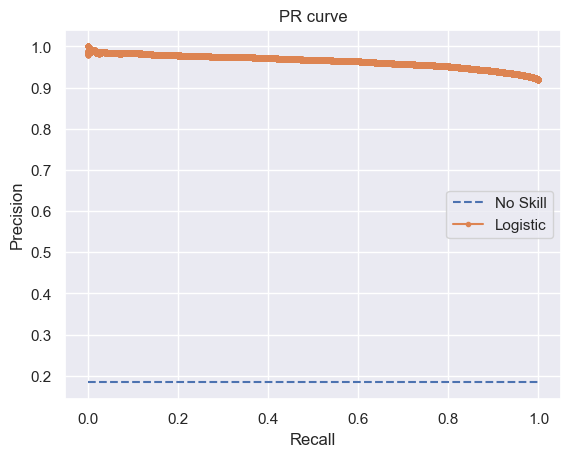

In [63]:
# Draw a PR curve
# Calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# Plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# Get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])
# Plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

## 8. Scorecard Creation

In [64]:
pd.DataFrame({'FICO Score': ['300-579', '580-669', '670-739', '740-799', '> 800-850'],
              'Variable Predictiveness' : ['Poor','Fair','Good','Very Good','Excelent']}).style.hide_index()
min_score, max_score = 300, 850

In [81]:
df_scorecard = summary_table
df_scorecard['Features'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard['SubFeatures'] = df_scorecard['Feature name'].str.split(':').str[1]

# Calculate the sum of the minimum & maximum coefficients of each category
min_sum_coef = df_scorecard.groupby('Features')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Features')['Coefficients'].max().sum()

# Create a new columns with the adjusted score
df_scorecard['Scores'] = (df_scorecard['Coefficients'] * (max_score - min_score) / 
                                       (max_sum_coef - min_sum_coef)).round()
df_scorecard.loc[0, 'Scores'] = (((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / 
                                               (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score).round()

In [82]:
pd.options.display.max_rows = None
df_scorecard[['Features','SubFeatures','Scores']]

,Features,SubFeatures,Scores
0,Intercept,NaN,587.0
1,CODE_GENDER,M,-5.0
2,CODE_GENDER,F,10.0
3,NAME_EDUCATION_TYPE,Academic degree,56.0
4,NAME_EDUCATION_TYPE,Higher education,2.0
5,NAME_EDUCATION_TYPE,Incomplete higher,-8.0
6,NAME_EDUCATION_TYPE,Lower secondary,-28.0
7,NAME_EDUCATION_TYPE,Secondary / secondary special,-18.0
8,NAME_FAMILY_STATUS,Single / not married,-1.0
9,NAME_FAMILY_STATUS,Civil marriage,-3.0


In [99]:
# Calculate credit score for all observations
X_test_woe_transformed = woe_transform.transform(X_test)
X_test_woe_transformed.insert(0, 'Intercept', 1)

scorecard_scores = df_scorecard['Scores'].to_frame().to_numpy()
y_scores = X_test_woe_transformed.dot(scorecard_scores)
X_test['Scores'] = y_scores.values

pd.options.display.max_rows = 10
X_test[['SK_ID_CURR','Scores']]

,SK_ID_CURR,Scores
128081,248559,610.0
68695,179677,575.0
280602,425076,590.0
93006,207998,541.0
125876,245968,553.0
...,...,...
145875,269139,670.0
164509,290700,582.0
57792,166977,480.0
172365,299738,557.0


## 9. Distribution Analysis

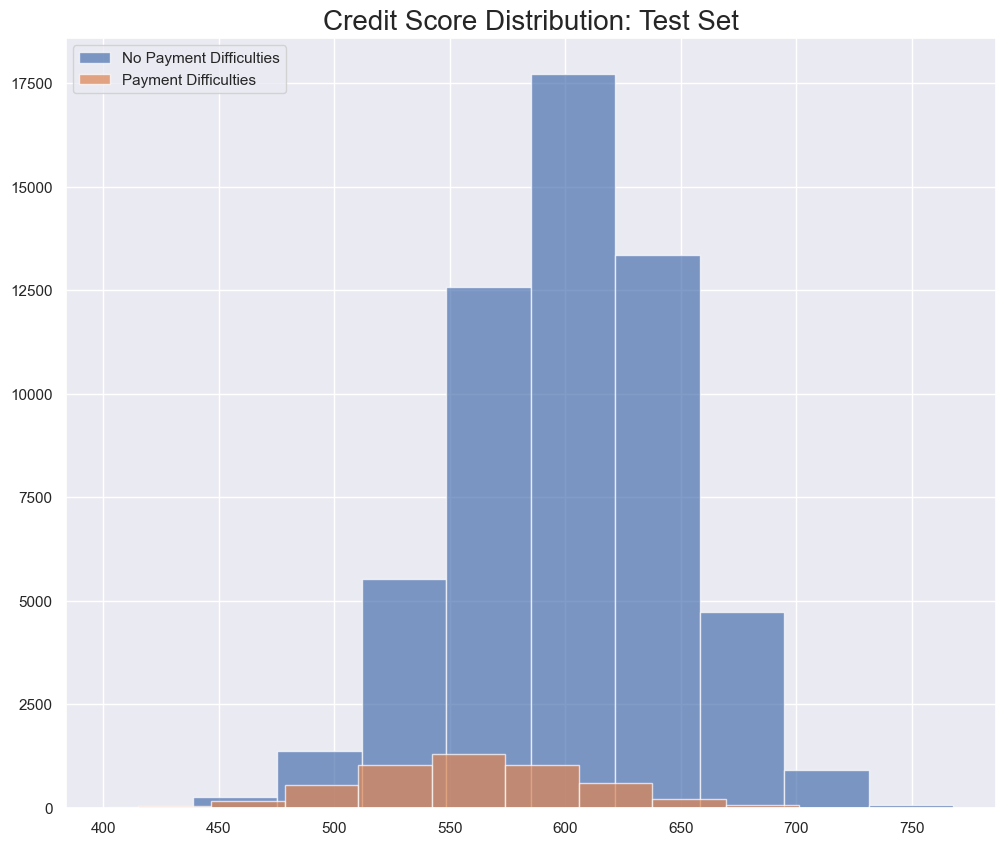

In [118]:
plt.figure(figsize=(12,10))
import random
import numpy
import math
from matplotlib import pyplot as plt

w = 40
n = math.ceil((X_test['Scores'].max() - X_test['Scores'].min())/w)
bins = numpy.linspace(-10, 10, 100)

plt.hist(X_test[y_test==1].Scores, alpha=0.7, label='No Payment Difficulties',bins = n)
plt.hist(X_test[y_test==0].Scores, alpha=0.7, label='Payment Difficulties',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=20)
plt.show()

#### Conclusion: 
With assumptions of the perfect theoritical model of FICO scorecard and inputs, a good model will clearly separate the blue/orange distribution; and have a smile shape, where:
1. Good customers (blue) with high credit scores to the very right
2. Default customers (orange) with low credit scores to the very left.

Unfortunately, the current model doesn’t separate these distributions very well. 